## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os, time, re
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, \
        qini_auc_score, uplift_auc_score
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, \
        plot_uplift_curve

from catboost import CatBoostClassifier


import sklift

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import os, time, re
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, \
        qini_auc_score, uplift_auc_score
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, \
        plot_uplift_curve

from catboost import CatBoostClassifier


import sklift

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

## Load transaction, customer, marketing (email, push, SMS etc data on SFMC), app data

In [3]:
#Load transaction & customer data 
trans = pd.read_csv("updated_trans.csv", encoding = 'utf-8')
con = pd.read_csv("updated_contact_wpointgender.csv", encoding = 'utf-8')
purchased = pd.read_csv("purchased_consumers_605_v2.csv", encoding = 'utf-8') #customer who purchased

#Email, push, SMS data on SFMC
sfmc = pd.read_csv("updated_sfmc_dt.csv", encoding = 'utf-8')
sfmc_grped = sfmc 

#App data on appsflyer
appsflyer = pd.read_csv("Notebook_time.csv", encoding = 'utf-8')
app = pd.read_csv("Merged_Time.csv", encoding = 'utf-8')

## Clean app data

In [4]:
trans = trans.rename(columns={"last_purchase_date": "Mths since last purchase"})
trans = trans.rename(columns={"amount_spent": "Amt Spent", "num_pdt_bought": "Products bought"})

apps_grped = appsflyer.groupby(["customer_user_id"])["days_spent_on_app", "recent_log_3months", "recent_log_4months", "recent_log_6months"].sum().reset_index()
apps_grped = apps_grped.rename(columns={"customer_user_id": "ma2_contactid__c"})
apps_grped = apps_grped.rename(columns={"recent_log_3months": "Num of logins in past 1 mth"})
apps_grped = apps_grped.rename(columns={"recent_log_4months": "Num of logins in past 3 mth"})
apps_grped = apps_grped.rename(columns={"recent_log_6months": "Num of logins in past 6 mth"})
apps_grped.head()

pages = ['redeem_coupon', 'rewards_tab_clicked','profile_filled'] 
sources = ['has_campaign', 'UNIVERSITY ROADSHOW', 'CUSTOM-LEAFLET', 'Canvas', 'Facebook', 'Instagram', 'QR', 'SMS','af_app_invites', 'googleadwords_int', 'organic', 'other_media_source']

app2 = app[['customer_user_id', 'redeem_coupon', 'homepage_banner_clicked', 'rewards_tab_clicked','profile_filled','has_campaign', 'UNIVERSITY ROADSHOW', 'CUSTOM-LEAFLET', 'Canvas', 'Facebook', 'Instagram', 'QR', 'SMS','af_app_invites', 'googleadwords_int', 'organic', 'other_media_source']]
app2 = app2.rename(columns={"customer_user_id": "ma2_contactid__c",  'redeem_coupon' : "Redeem coupon", 'rewards_tab_clicked': "Rewards tab clicked",'profile_filled' : "Profile filled",'has_campaign' :"Campaign flag", 'UNIVERSITY ROADSHOW' : "App source_Uni roadshow", 'CUSTOM-LEAFLET': "App source_Leaflet", 'Canvas' :"App source_Canvas", 'Facebook' :"App source_FB", 'Instagram': "App source_Insta", 'QR': "App source_QR", 'SMS': "App source_SMS",'af_app_invites':'App source_Affliate', 'googleadwords_int': 'App source_Google ads', 'organic':'App source_Organic', 'other_media_source':'App source_Others'})

appsflyer.head()

,customer_user_id,min_app_time,max_app_time,avg_app_time,app_first_log,app_last_log,days_spent_on_app,recent_log_3months,recent_log_4months,recent_log_6months
0,HKG---C0032O,0:00:00,4:51:14,0:31:02,12/4/2019,4/21/2022,11,2,2,2
1,HKG---C0049N,0:00:00,6:43:45,1:05:53,8/31/2020,10/28/2021,7,0,0,0
2,HKG---C0091K,0:00:00,10:25:18,3:05:11,12/16/2020,1/25/2022,5,0,0,1
3,HKG---C0107I,0:00:00,10:21:59,0:24:58,11/13/2020,11/18/2021,30,0,0,0
4,HKG---C0130N,3:13:43,3:13:43,3:13:43,8/9/2021,8/9/2021,1,0,0,0


In [5]:
appsflyer.columns

Index(['customer_user_id', 'min_app_time', 'max_app_time', 'avg_app_time',
       'app_first_log', 'app_last_log', 'days_spent_on_app',
       'recent_log_3months', 'recent_log_4months', 'recent_log_6months'],
      dtype='object')

## Load data for coupons & products

In [6]:
coup = pd.read_csv("coupon_joined_contact.csv", encoding = 'utf-8')

pdt = pd.read_csv("Transaction_level_df.csv", encoding = 'utf-8')

coup = coup[coup["ma2_couponused__c"] == True]

## Clean transaction + coupon data

In [7]:
#Get Transactions WITH coupon only
trans_coup = pd.merge(coup, pdt, left_on=['ma2_transactionid__c', 'ma2_contactid__c'], right_on =['id',  'ma2_contactid__c'], how='inner')

#All transactions
trans_moreinfo = pd.merge(coup, pdt, left_on=['ma2_transactionid__c', 'ma2_contactid__c'], right_on =['id',  'ma2_contactid__c'], how='outer')

trans_coup["startdate__c"] = pd.to_datetime(trans_coup["startdate__c"], format = '%Y-%m')
trans_coup["createddate_y"] = pd.to_datetime(trans_coup["createddate_y"], format = '%Y-%m')

trans_coup["Days since coup issue"] = (trans_coup["createddate_y"] - trans_coup["startdate__c"]).dt.days

trans_coup = trans_coup[['ma2_contactid__c', 'Days since coup issue',
       'ma2_couponname__c', 'ma2_quantity__c', 'category', 'createddate_y', 'pack_size', 'total_no_of_lenses',
       'product_quantity', 'brand_category', 'product_price',
       'gross_price', 'brand_name', 'ma2_transactionid__c'
]]

first = trans_coup.groupby(['ma2_contactid__c'])['createddate_y'].min()
first = pd.merge(trans_coup, first, on =['ma2_contactid__c', 'createddate_y'], how='right')

Text(0, 0.5, 'Count')

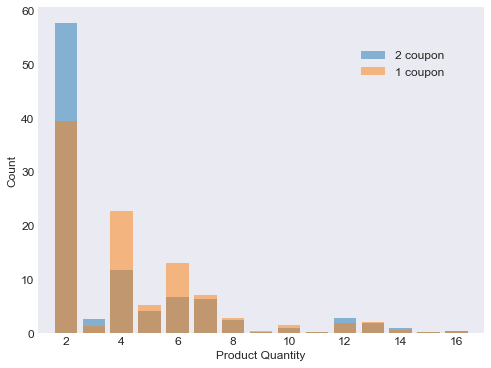

In [8]:
#Get Transactions which used 1 Coupon
plt.style.use('seaborn-dark')
grp = first.groupby(['ma2_contactid__c'])['ma2_couponname__c', 'category'].count()
grp1 = grp[grp["ma2_couponname__c"] == 1].reset_index()["ma2_contactid__c"]

trans_unique = pd.merge(grp1, first, on =['ma2_contactid__c'], how='left')

#Get Transactions which used 2 Coupon
grp2 = grp[grp["ma2_couponname__c"] == 2].reset_index()["ma2_contactid__c"]
trans_2coup = pd.merge(grp2, first, on =['ma2_contactid__c'], how='left')

coup2 = trans_2coup["product_quantity"].value_counts(normalize=True).mul(100)

coup1 = trans_unique["product_quantity"].value_counts(normalize=True).mul(100)

coup1r = coup1.reset_index()
coup2r = coup2.reset_index()

plt.figure(figsize=(8,6))
plt.bar(x = coup2r["index"], height = coup2r["product_quantity"], alpha=0.5, label="data1") #b
plt.bar(x = coup1r["index"], height = coup1r["product_quantity"], alpha=0.5, label="data2")
plt.xlim(1,17)
plt.xlabel("Product Quantity",  fontsize= 12)
plt.legend(["2 coupon", "1 coupon"], ncol=1, loc="upper left", bbox_to_anchor=(0.7,0.9),  fontsize= 12)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ylabel("Count",  fontsize= 12)

From the above, customers who used 2 coupons tend to purchase more

In [9]:
trans_unique["brand_category"] = trans_unique["brand_category"].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x.split()[0]))

trans_unique["pack_size"] = trans_unique["pack_size"].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x.split()[0]))

trans_unique["brand_name"] = trans_unique["brand_name"].apply(lambda x: re.sub('[^A-Za-z0-9 -]+', '', x.split(",")[0]))

trans_unique.columns

Index(['ma2_contactid__c', 'Days since coup issue', 'ma2_couponname__c',
       'ma2_quantity__c', 'category', 'createddate_y', 'pack_size',
       'total_no_of_lenses', 'product_quantity', 'brand_category',
       'product_price', 'gross_price', 'brand_name', 'ma2_transactionid__c'],
      dtype='object')

## Merge datasets & clean

In [10]:
#Merge transaction & customer data
m = pd.merge(trans, con, on='ma2_contactid__c',how='right')

#Merge marketing data
m1 = pd.merge(m, sfmc_grped, on='ma2_contactid__c',how='left')

#Merge app data
m2 = pd.merge(m1, apps_grped,on='ma2_contactid__c',how='left')
m3 = pd.merge(m2, app2,on='ma2_contactid__c',how='left')

#Fill NA with 0s
m3['Total points'] = m3['Total points'].fillna(0)
m3['Amt Spent'] = m3['Amt Spent'].fillna(0)
m3['Products bought'] = m3['Products bought'].fillna(0)
m3['Mths since last purchase'] = m3['Mths since last purchase'].fillna(0)

#Remove outliers from age column - values that are too high or low
m3.loc[(m3['Age'] < 8 ), 'Age']=np.nan
m3.loc[(m3['Age'] > 100 ), 'Age']=np.nan

#Remove outliers from marketing column - values that are too high
m3.loc[(m3['channel_Email'] > 300 ), 'channel_Email'] = np.nan

#Remove outliers from prodict column - values that are too high
lim = np.nanpercentile(m3["Products bought"], 99.9)
m3 = m3[m3["Products bought"] < lim ]

#Create feature for MyAcuvue user
m3["App User"] = np.where(m3["days_spent_on_app"].isna() , 0, 1)

#Cluster
m3["Cluster"] = np.where(m3["Products bought"] == 0, 0, 1)
m3["Cluster"].value_counts()

0    109946
1     93841
Name: Cluster, dtype: int64

In [11]:
m3["Gender"] = m3["Gender"].replace({"Female": 1, "Male": 0})
m3["Length of wearing CL"] = m3["Length of wearing CL"].replace({"6個月以上": 1, "More than 6 months": 1, "6個月以": 1, "0-6個月": 0, "Less than 6 months": 0})

# Select X variables

In [12]:
m5 = m3
purchased = pd.read_csv("purchased_consumers_605_v2.csv", encoding = 'utf-8')

m5 = m5.reset_index(drop= True)

for i in range(len(purchased)):
    idx = list(m5["ma2_contactid__c"]).index(purchased["ma2_contactid__c"][i])
    m5["Cluster"][idx] = 1
    

m5["Cluster"].value_counts()

0    109946
1     93841
Name: Cluster, dtype: int64

In [13]:
m6 = m3[['Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_Early Morning',
       'time_Evening', 'time_Late Night', 'time_Morning', 'time_Night',
       'time_Noon', 'days_spent_on_app', 'Num of logins in past 1 mth',
       'Num of logins in past 3 mth', 'Num of logins in past 6 mth',
       'Campaign flag']]

In [14]:
y = m5["Cluster"]
X = m6

In [15]:
RND = 42            # random state 
TST = 0.3           # % of dataset to reserve for testing
THREADc = 2         # number of parallel threads to use

In [16]:
y.value_counts()

0    109946
1     93841
Name: Cluster, dtype: int64

# Base uplift 

In [17]:
X = m3[['Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender','days_spent_on_app',
       'Num of logins in past 3 mth', 'channel_Email',
       'channel_Inbox Only', 'channel_PN + Inbox', 'channel_PushNotification',
       'channel_SMS', 'App source_Uni roadshow',
       'App source_Leaflet', 'App source_Canvas', 'App source_FB',
       'App source_Insta', 'App source_QR', 'App source_SMS',
       'App source_Affliate', 'App source_Google ads', 'App source_Organic',
       'App source_Others', 'Campaign flag']]

In [18]:
ls = ['Campaign flag']

average uplift: -0.0782


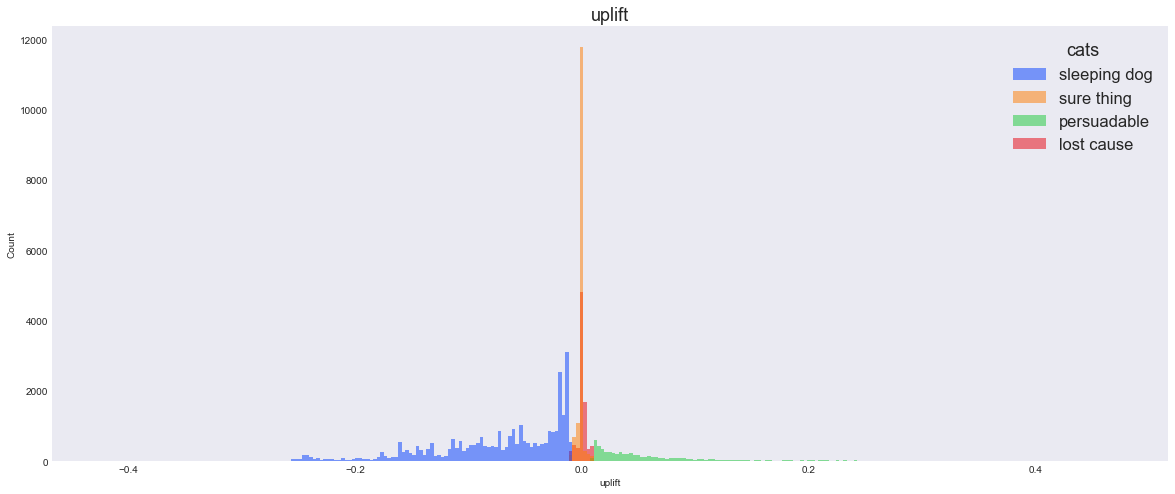

In [19]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=10)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.10), "cats"] = "lost cause"
    #0.2
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [20]:
dfZ.groupby("cats")["uplift"].describe().T

cats,sleeping dog,sure thing,persuadable,lost cause
count,"31,439.00","14,395.00","6,865.00","8,438.00"
mean,-0.08,-0.00,0.07,0.00
std,0.06,0.00,0.07,0.00
min,-0.42,-0.01,0.01,-0.01
25%,-0.11,-0.00,0.02,-0.00
50%,-0.06,-0.00,0.05,0.00
75%,-0.02,0.00,0.09,0.00
max,-0.01,0.01,0.47,0.01


In [21]:
output_day = output_df

output_day.sort_values("Uplift Score", ascending = False, inplace = True)
output_day.index = np.arange(1,len(output_day)+1)
output_day

,Variable,Uplift Score
1,Campaign flag,-0.08


# Best Day

In [22]:
X = m3[['Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender','days_spent_on_app',
       'Num of logins in past 3 mth', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday']]

In [23]:
ls = ['day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']

average uplift: 0.2071
average uplift: 0.2120
average uplift: 0.2362
average uplift: 0.2041
average uplift: 0.1954
average uplift: 0.2265
average uplift: 0.1743


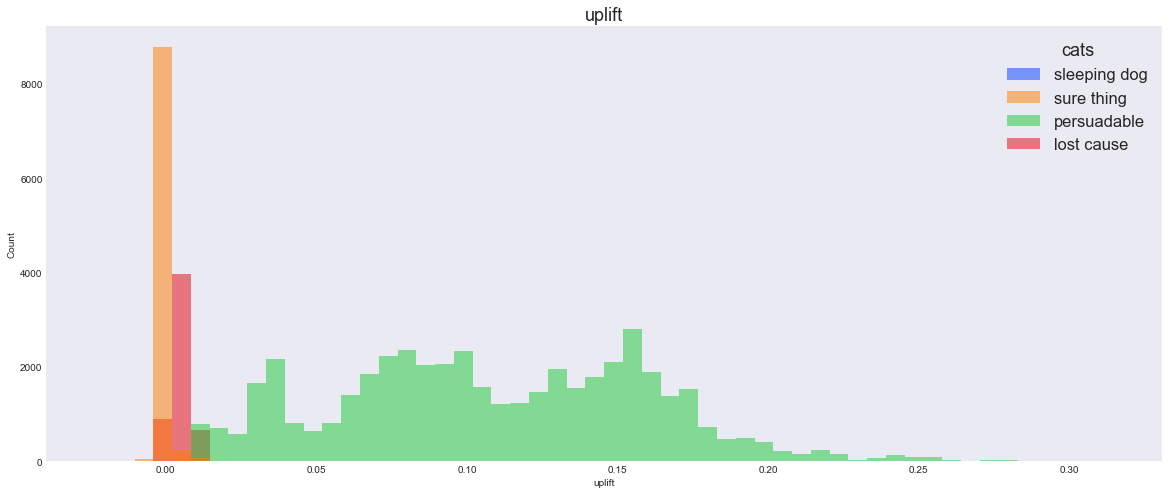

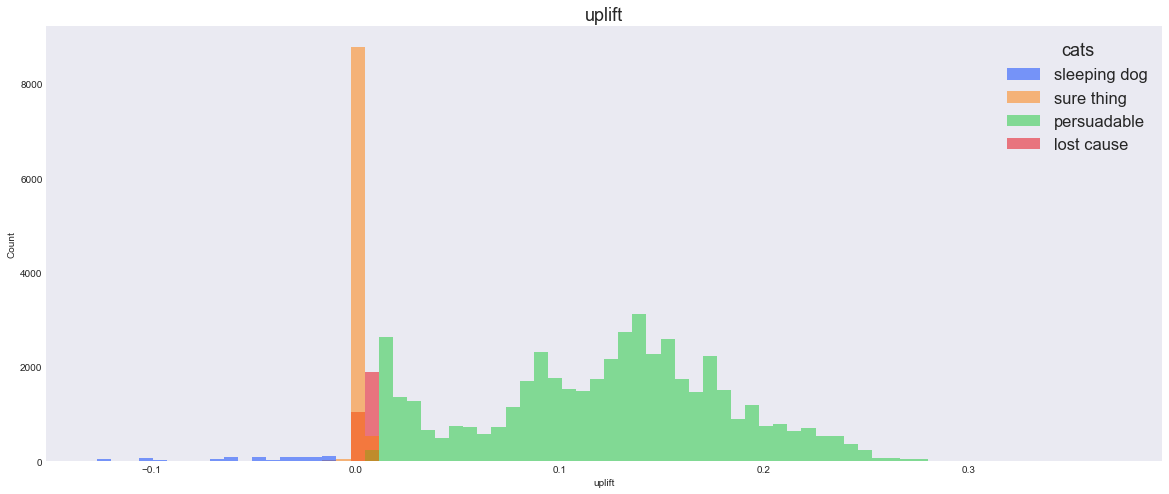

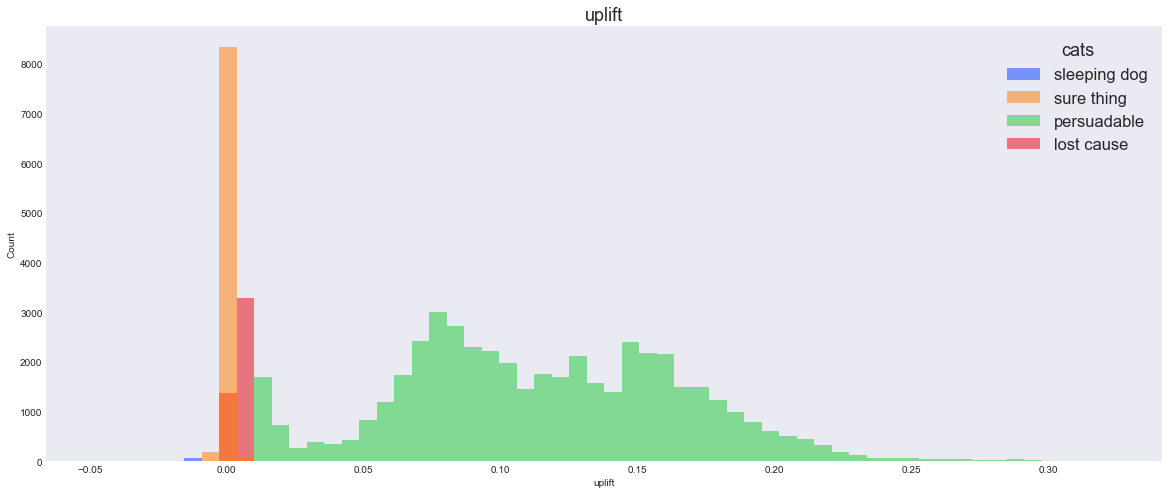

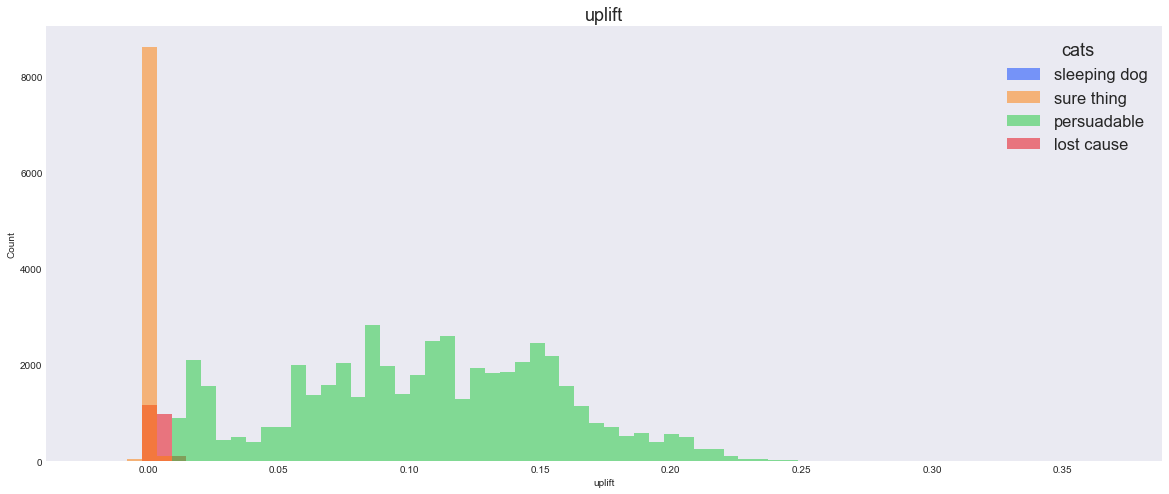

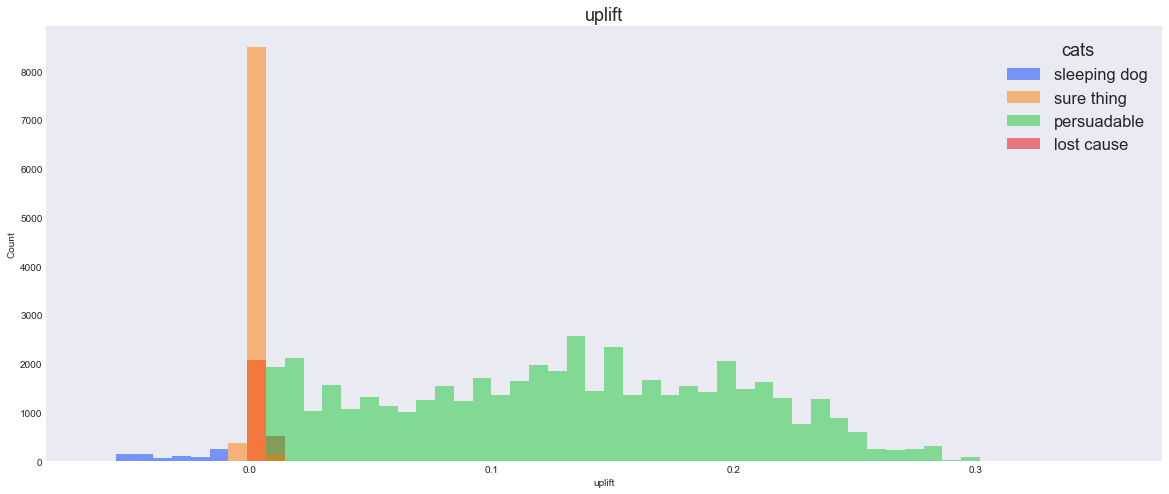

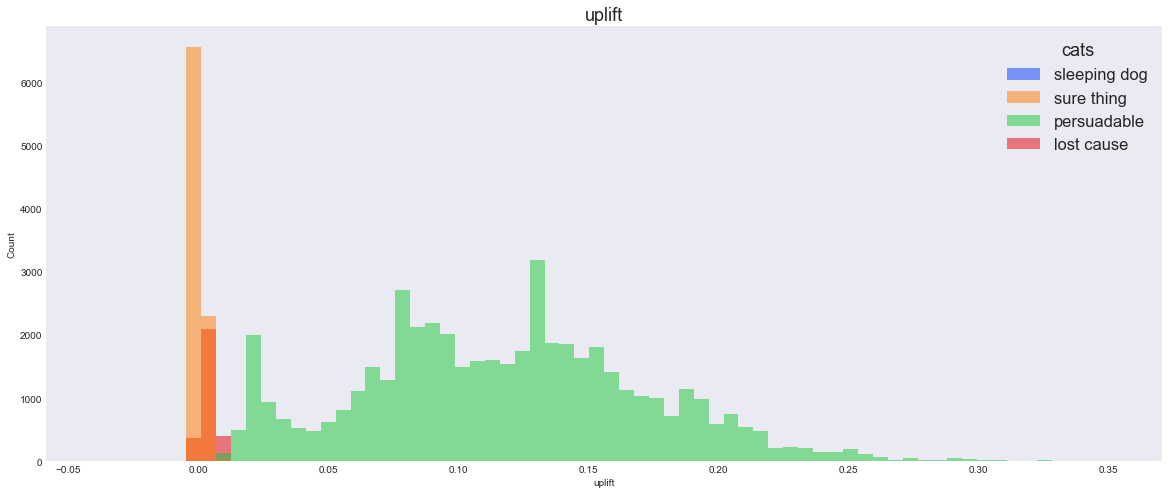

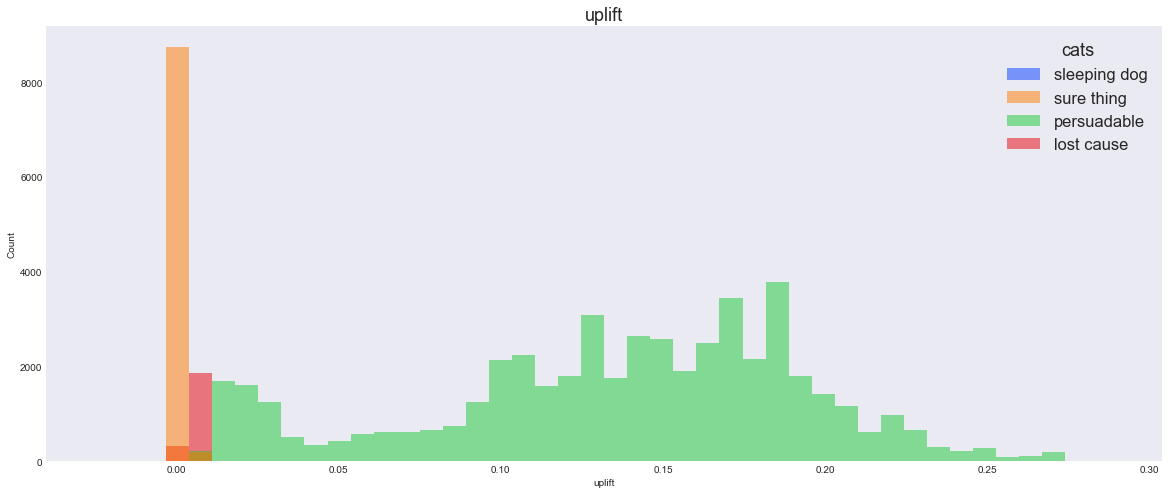

In [24]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=10)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [25]:
output_day = output_df

output_day.sort_values("Uplift Score", ascending = False, inplace = True)
output_day.index = np.arange(1,len(output_day)+1)
output_day

,Variable,Uplift Score
1,day_Saturday,0.24
2,day_Tuesday,0.23
3,day_Monday,0.21
4,day_Friday,0.21
5,day_Sunday,0.20
6,day_Thursday,0.20
7,day_Wednesday,0.17


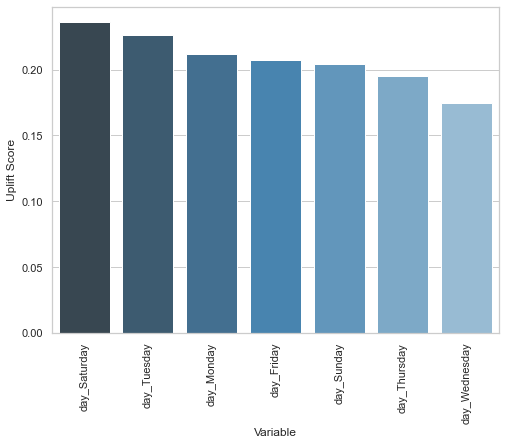

In [26]:
plt.figure(figsize=(8,6))
sns.set(style="whitegrid", color_codes=True)

data = output_day.reset_index()

pal = sns.color_palette("Blues_d", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()

### The best days to send marketing information is 1. Sat, 2. Tues then 3. Monday 4. Friday 5. Sunday

# Best timing

In [28]:
X = m3[['Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_Early Morning',
       'time_Evening', 'time_Late Night', 'time_Morning', 'time_Night',
       'time_Noon', 'days_spent_on_app', 'Num of logins in past 1 mth',
       'Num of logins in past 3 mth', 'Num of logins in past 6 mth',
       'Campaign flag']]

In [29]:
ls = ['time_Early Morning',
       'time_Evening', 'time_Late Night', 'time_Morning', 'time_Night',
       'time_Noon']

average uplift: 0.2025
average uplift: 0.2903
average uplift: 0.1775
average uplift: 0.2786
average uplift: 0.2744
average uplift: 0.2858


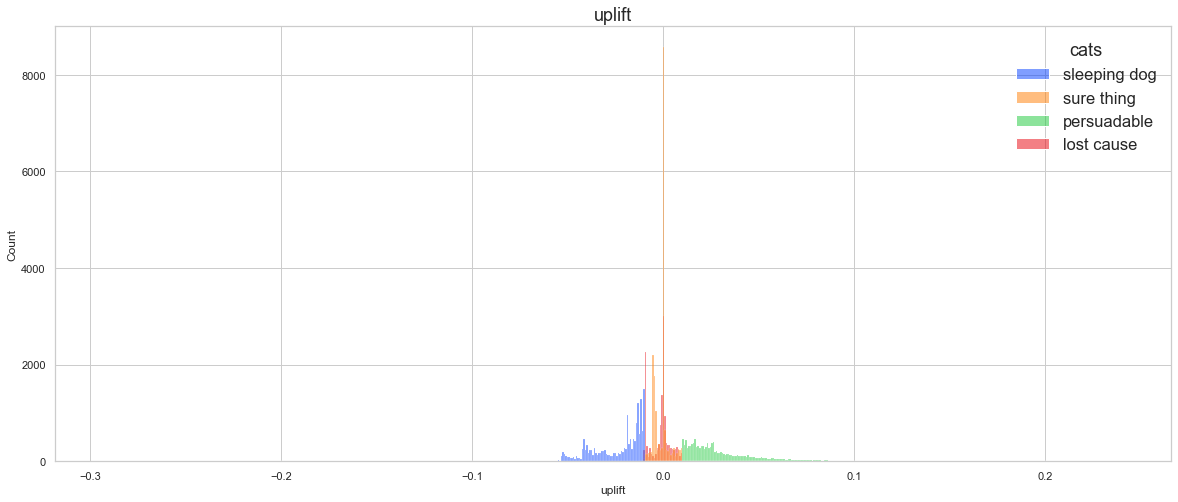

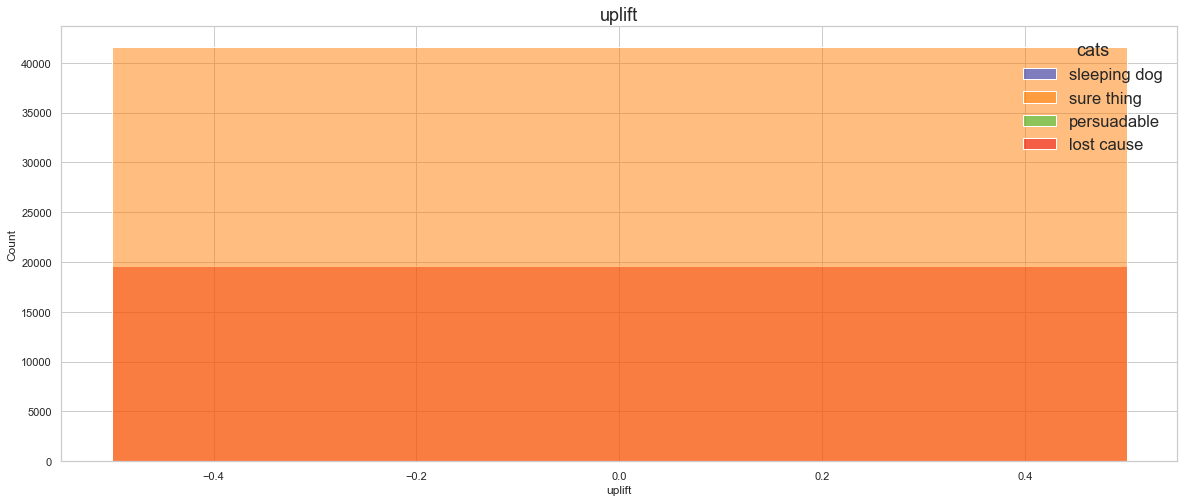

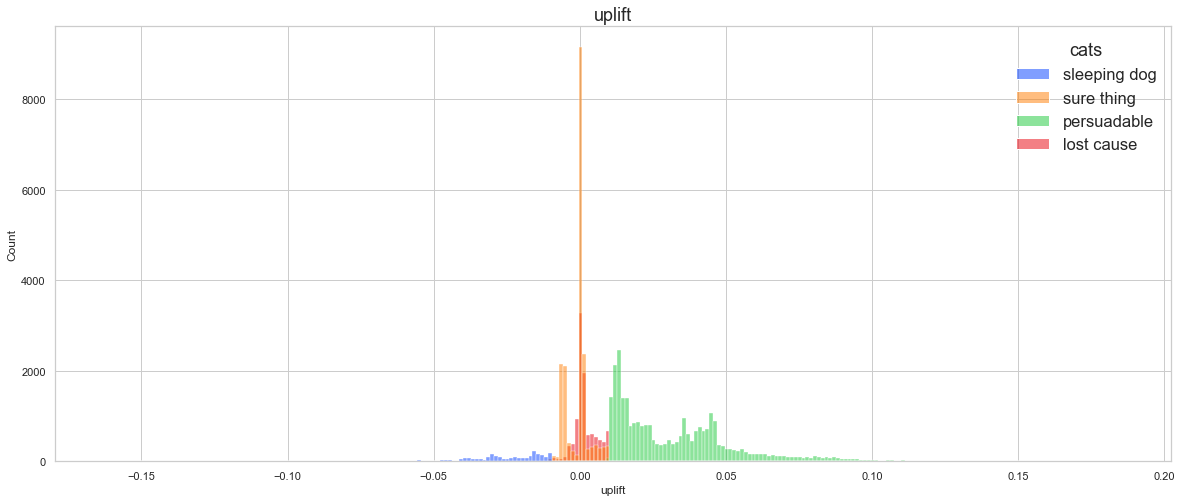

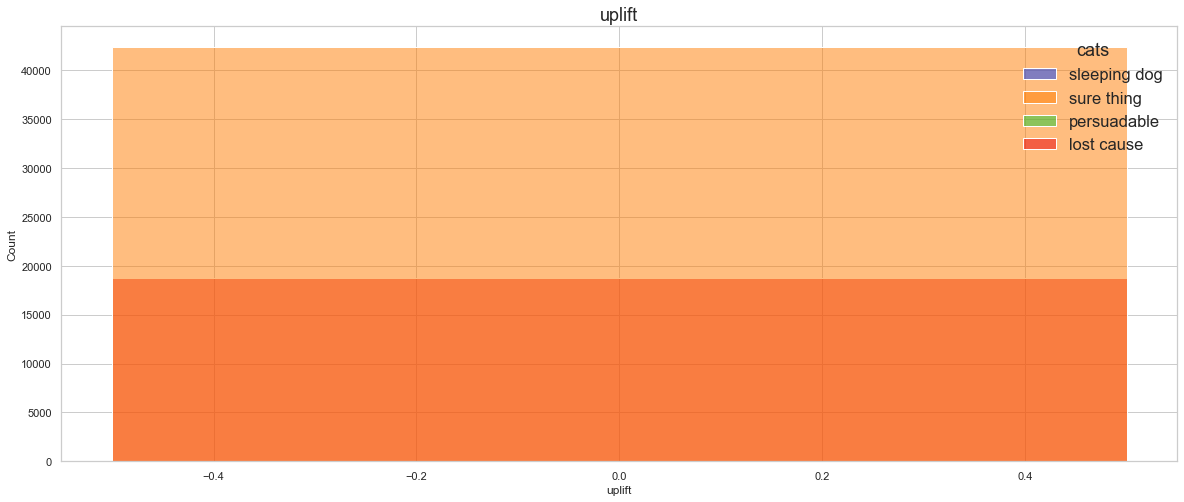

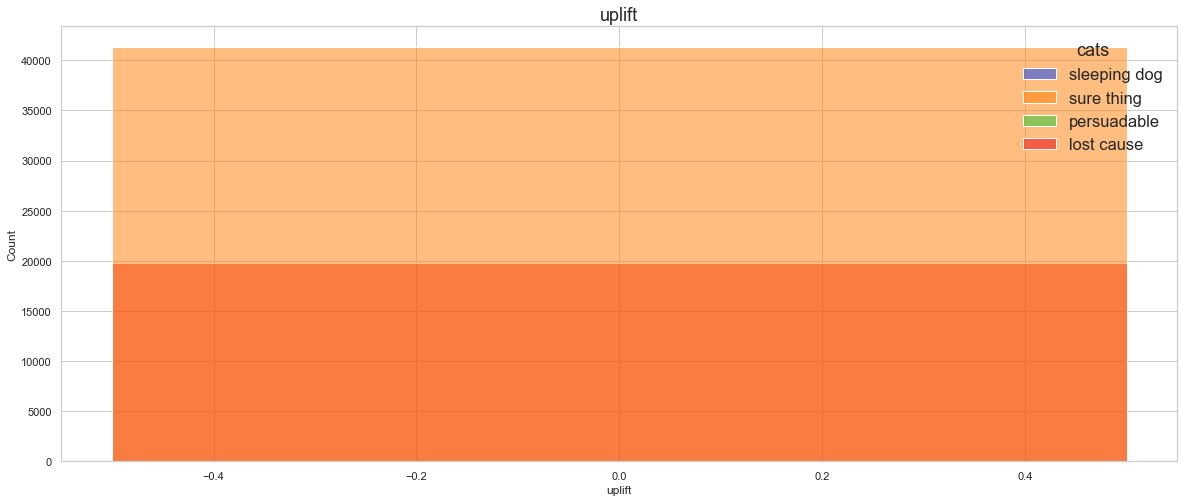

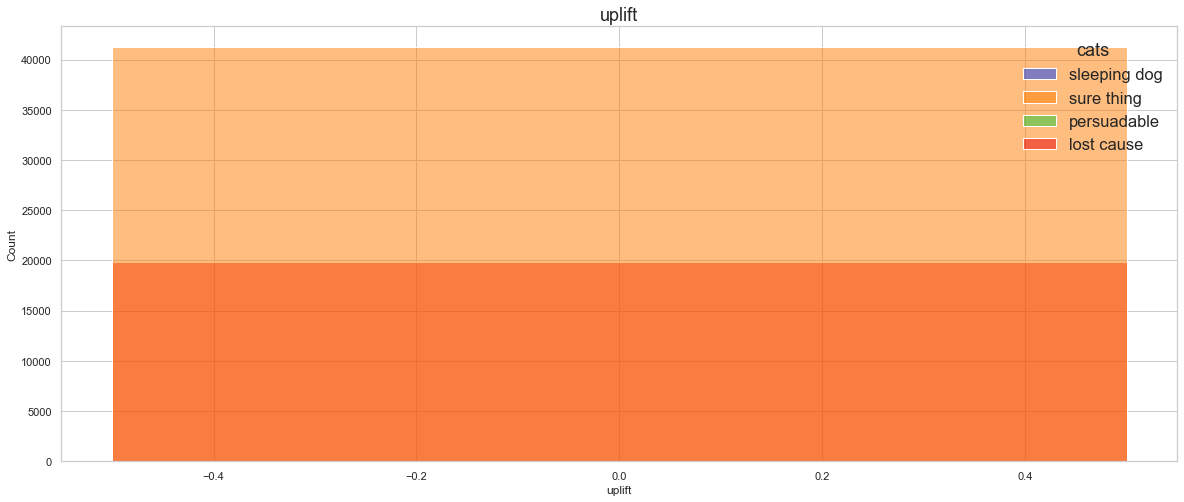

In [30]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=10)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [31]:
output_time = output_df

In [32]:
output_time.sort_values("Uplift Score", ascending = False, inplace = True)
output_time.index = np.arange(1,len(output_time)+1)
output_time

,Variable,Uplift Score
1,time_Evening,0.29
2,time_Noon,0.29
3,time_Morning,0.28
4,time_Night,0.27
5,time_Early Morning,0.20
6,time_Late Night,0.18


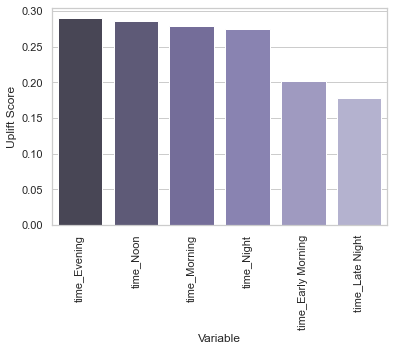

In [33]:
sns.set(style="whitegrid", color_codes=True)

data = output_time.reset_index()

pal = sns.color_palette("Purples_d", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()


### The best timing to send marketing information is 1. Evening, 2. Noon 3. Morning then 4. Night

# Best app source

In [34]:
X = m3[['Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_Early Morning',
       'time_Evening', 'time_Late Night', 'time_Morning', 'time_Night',
       'time_Noon', 'days_spent_on_app', 'Num of logins in past 1 mth',
       'Num of logins in past 3 mth', 'Num of logins in past 6 mth',
       'Campaign flag','App source_Uni roadshow',
       'App source_Leaflet', 'App source_Canvas', 'App source_FB',
       'App source_Insta', 'App source_QR', 'App source_SMS',
       'App source_Affliate', 'App source_Google ads', 'App source_Organic',
       'App source_Others']]

In [35]:
ls = ['App source_Uni roadshow',
       'App source_Leaflet', 'App source_Canvas', 'App source_FB',
       'App source_Insta', 'App source_QR', 'App source_SMS',
       'App source_Affliate', 'App source_Google ads', 'App source_Organic',
       'App source_Others']

average uplift: 0.4995
average uplift: 0.4581
average uplift: -0.3153
average uplift: -0.4081
average uplift: -0.3787
average uplift: 0.4907
average uplift: -0.1009
average uplift: 0.3454
average uplift: -0.4428
average uplift: 0.4519
average uplift: -0.0712


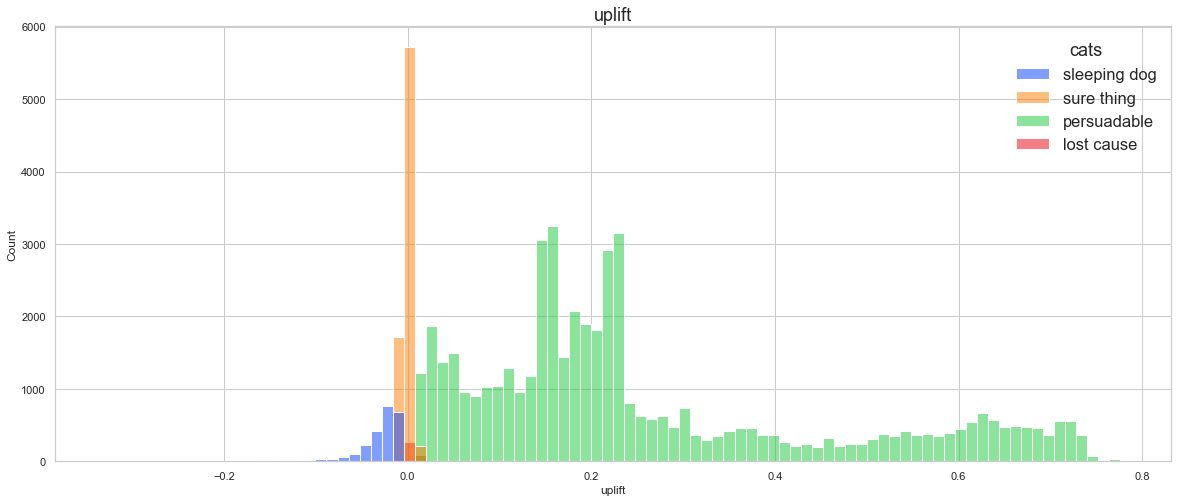

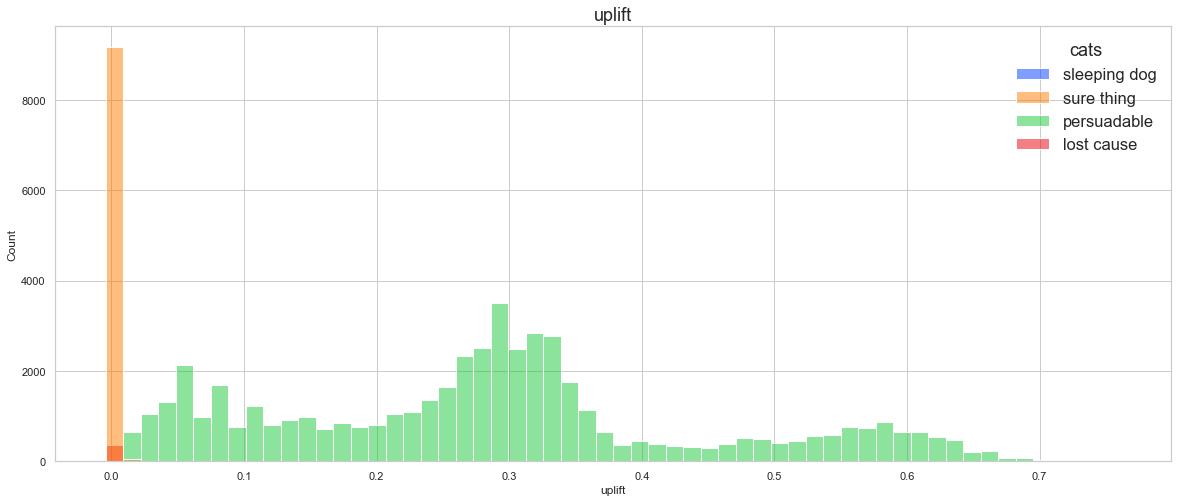

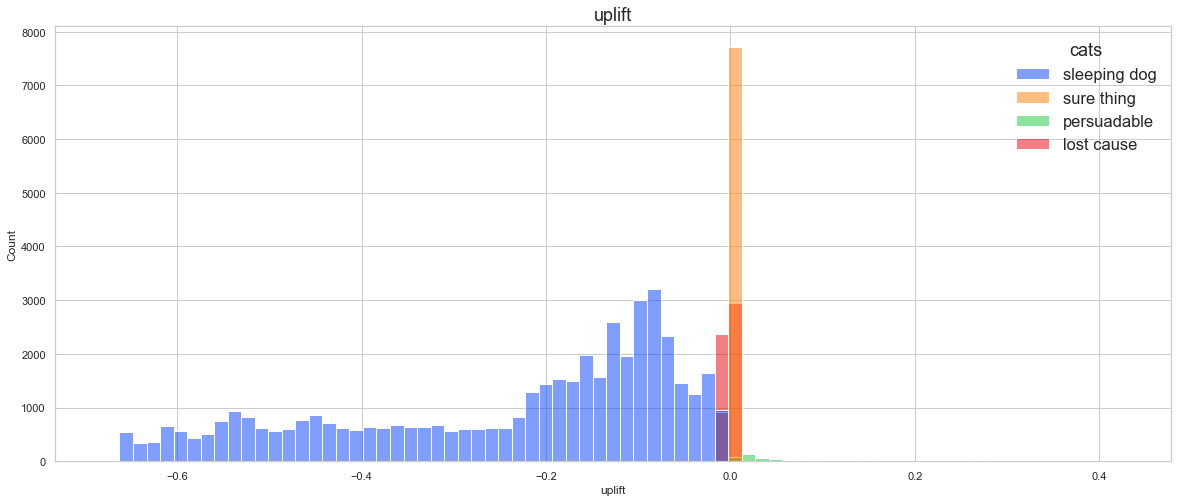

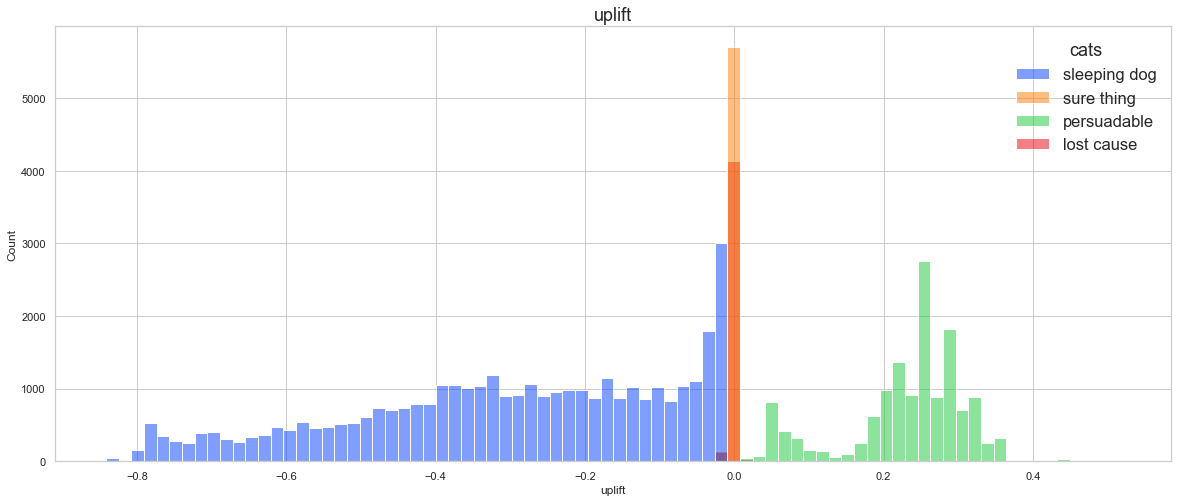

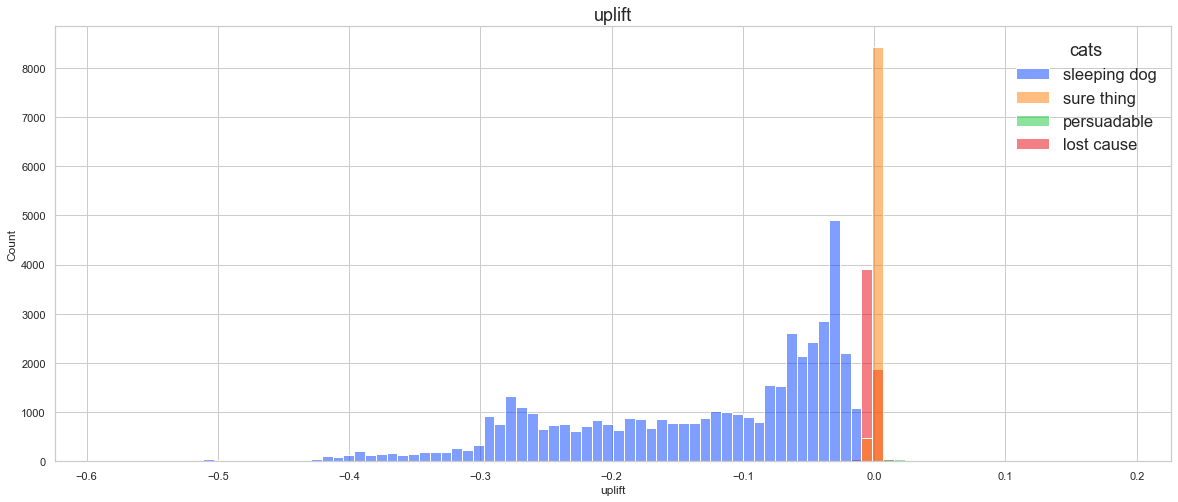

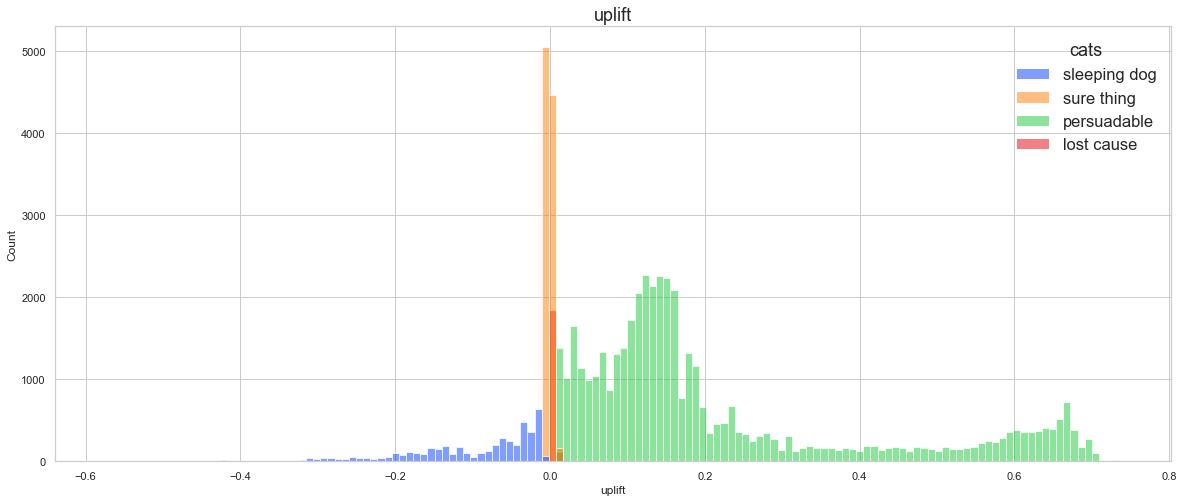

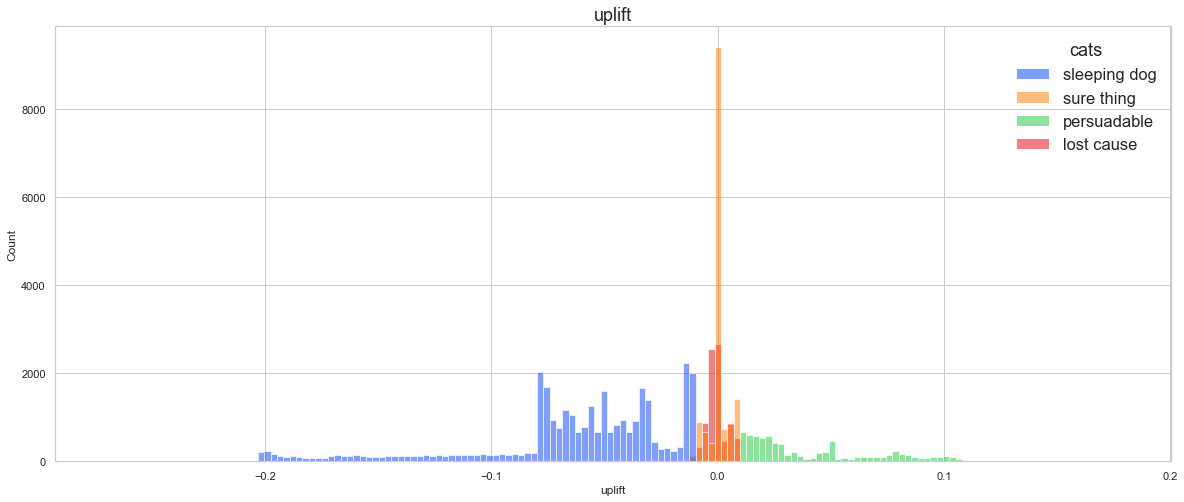

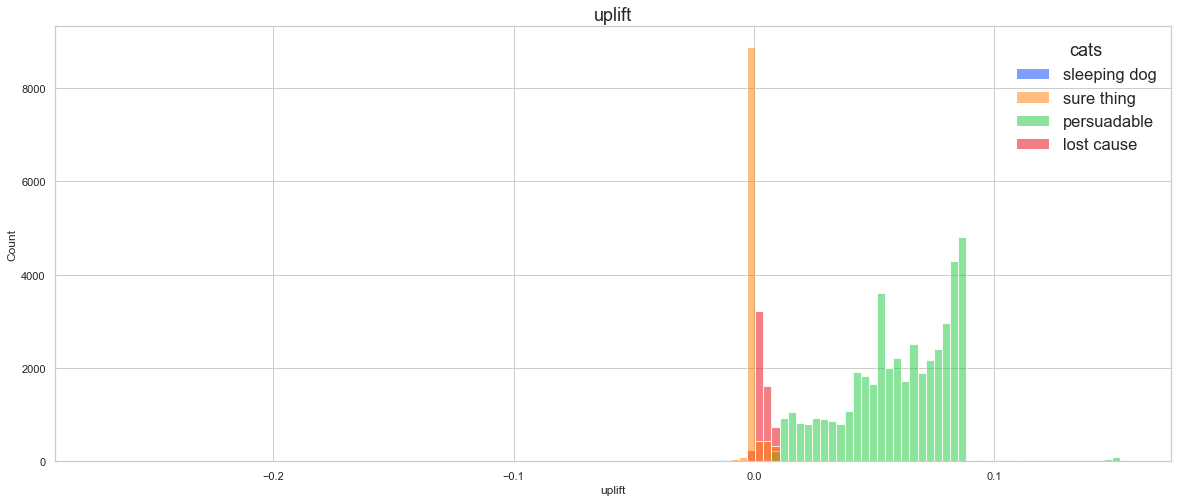

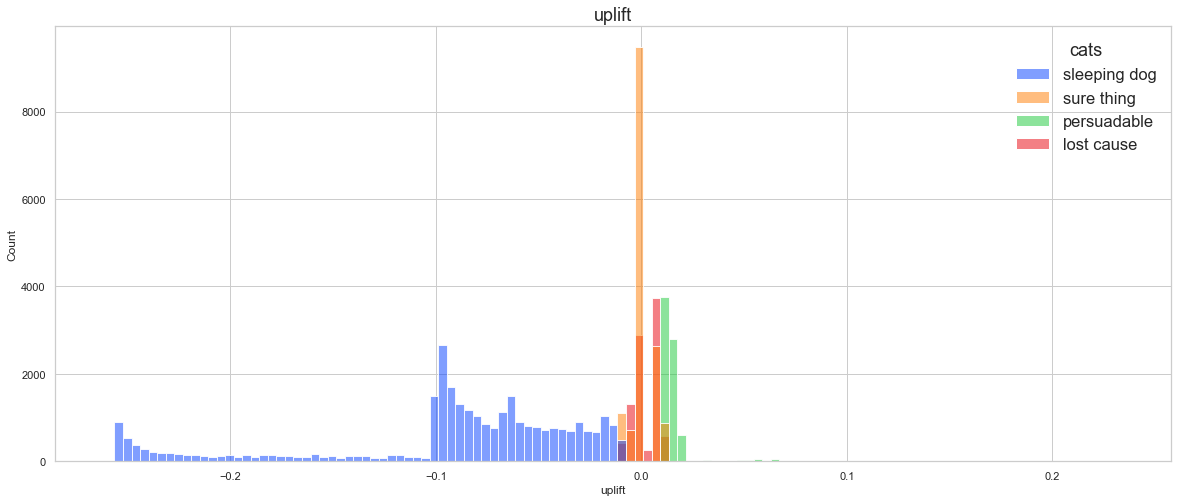

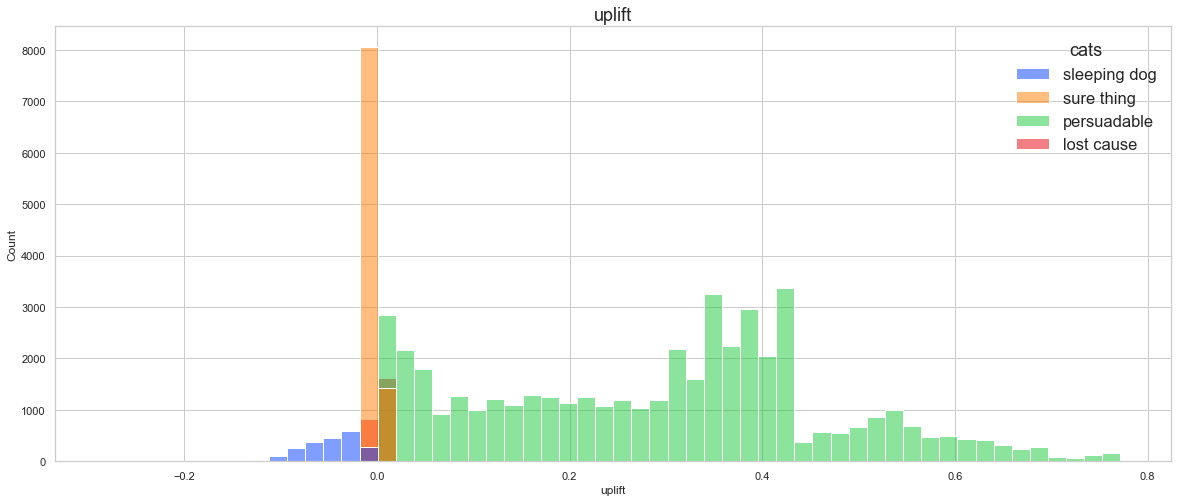

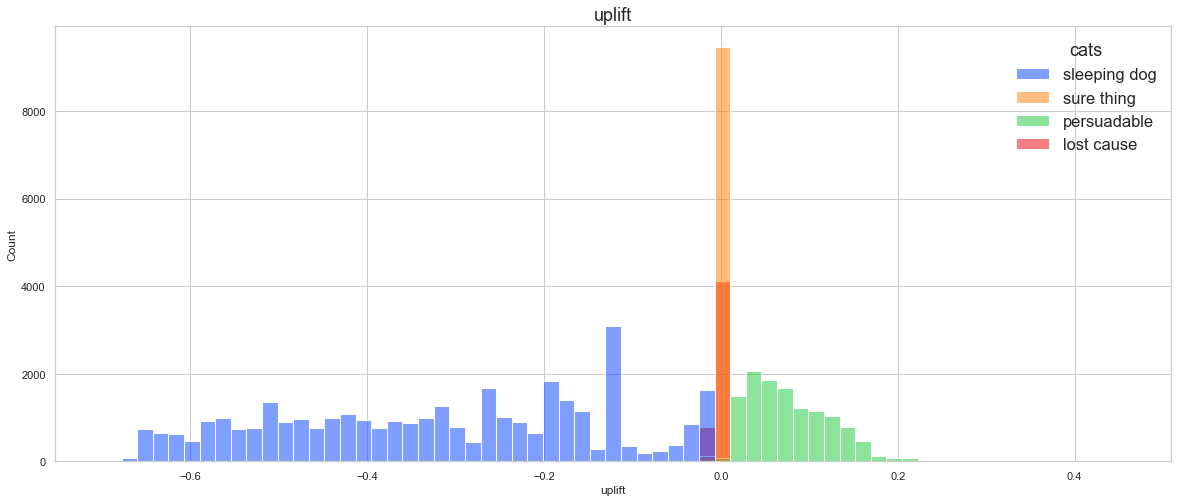

In [36]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=2)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [37]:
output_source = output_df
output_source.sort_values("Uplift Score", ascending = False, inplace = True)
output_source.index = np.arange(1,len(output_source)+1)
output_source

,Variable,Uplift Score
1,App source_Uni roadshow,0.50
2,App source_QR,0.49
3,App source_Leaflet,0.46
4,App source_Organic,0.45
5,App source_Affliate,0.35
6,App source_Others,-0.07
7,App source_SMS,-0.10
8,App source_Canvas,-0.32
9,App source_Insta,-0.38
10,App source_FB,-0.41


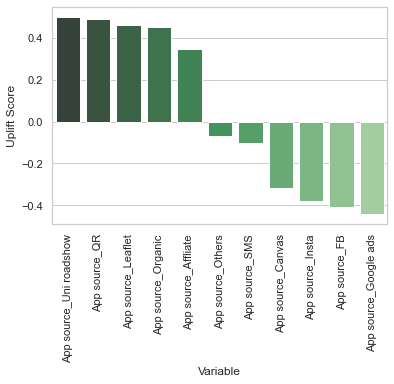

In [38]:
sns.set(style="whitegrid", color_codes=True)

data = output_source.reset_index()

pal = sns.color_palette("Greens_d", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()

### The most effective referall channels for app usage are 
1. University roadshow
2. Q
3. Leaflet

# Coupon Type

In [40]:
X = m3[['ma2_contactid__c', 'Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender','days_spent_on_app',
       'Num of logins in past 3 mth', 'channel_Email',
       'channel_Inbox Only', 'channel_PN + Inbox', 'channel_PushNotification',
       'channel_SMS', 'App source_Uni roadshow',
       'App source_Leaflet', 'App source_Canvas', 'App source_FB',
       'App source_Insta', 'App source_QR', 'App source_SMS',
       'App source_Affliate', 'App source_Google ads', 'App source_Organic',
       'App source_Others']]

In [42]:
#Goal is use coupon
new_var = pd.get_dummies(trans_unique[['category', 'ma2_contactid__c', 'Days since coup issue']], columns = ['category'], prefix='', prefix_sep='')
X = pd.merge(new_var, X, on='ma2_contactid__c',how='left')

y = pd.merge(trans, X, on='ma2_contactid__c',how='right')
X = X.drop(['ma2_contactid__c', 'Days since coup issue'], axis=1)

y = y['Days since coup issue']

def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

y = pct_rank_qcut(y, 2)
y = y.replace({1: 0, 2: 1})

In [43]:
ls = ['Discount_Cash', 'Discount_Loyalty', 'Welcome']

average uplift: -0.6585
average uplift: 0.1689
average uplift: 0.4738


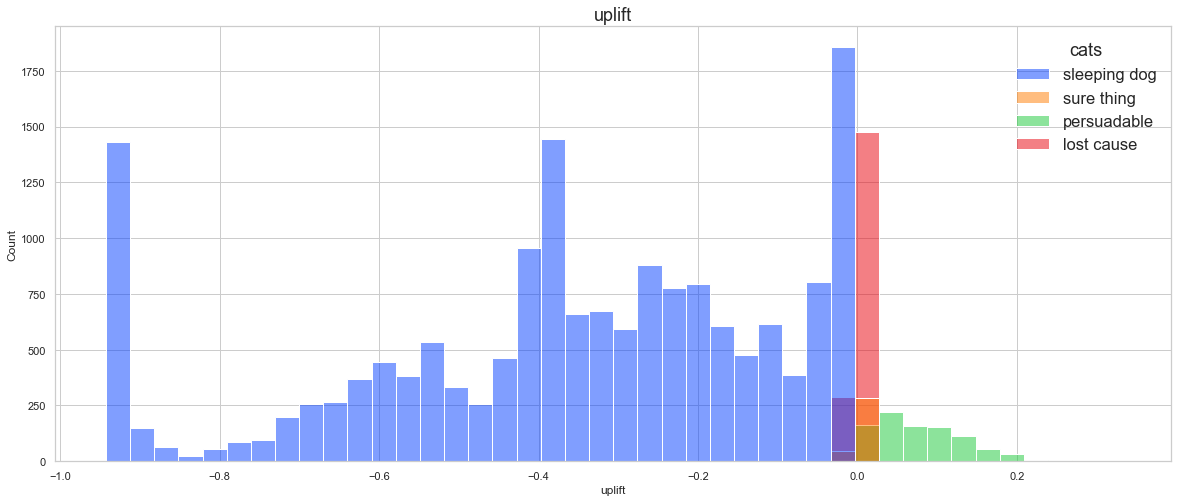

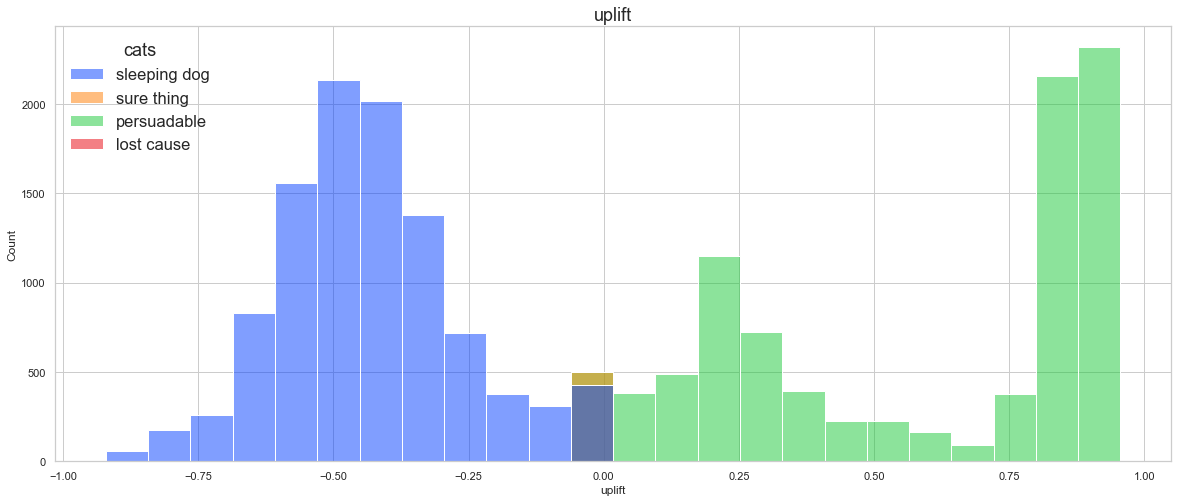

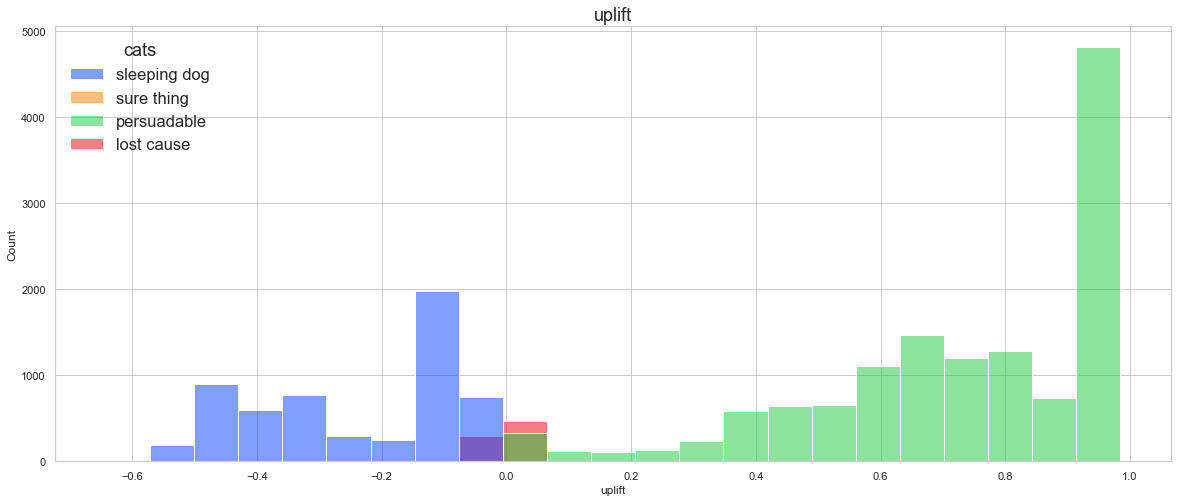

In [44]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1) #X.drop([var], axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=10)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [45]:
dfZ.groupby("cats")["uplift"].describe().T

cats,sleeping dog,sure thing,persuadable,lost cause
count,"5,747.00",6.00,"13,420.00",759.00
mean,-0.24,0.00,0.73,-0.00
std,0.16,0.00,0.24,0.00
min,-0.64,-0.00,0.01,-0.01
25%,-0.39,0.00,0.60,-0.01
50%,-0.17,0.00,0.78,0.00
75%,-0.10,0.00,0.95,0.00
max,-0.01,0.01,0.98,0.01


In [46]:
dfZ.groupby("cats").sum().sort_values(by = "uplift") #["Confirmed"#(order = ascending)

,prob_treat,prob_control,uplift
cats,,,
sleeping dog,187.27,"1,568.73","-1,381.46"
lost cause,33.83,35.50,-1.67
sure thing,1.44,1.43,0.01
persuadable,"11,136.49","1,306.91","9,829.58"


In [48]:
output_coup = output_df
output_coup = output_coup.set_index("Variable")
output_coup.sort_values("Uplift Score", ascending = False, inplace = True)
output_coup

,Uplift Score
Variable,
Welcome,0.47
Discount_Loyalty,0.17
Discount_Cash,-0.66


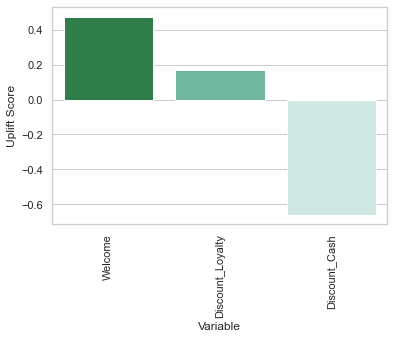

In [49]:
sns.set(style="whitegrid", color_codes=True)

data = output_coup.reset_index()

pal = sns.color_palette("BuGn", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()

### The most effective coupons resulting in quicker coupon usage is: 1. welcome coupon > 2. discount loyalty coupon > 3. discount cash coupon

average uplift: -0.1233
average uplift: 0.2570
average uplift: -0.1248


,Uplift Score
Variable,
Discount_Loyalty,0.26
Discount_Cash,-0.12
Welcome,-0.12


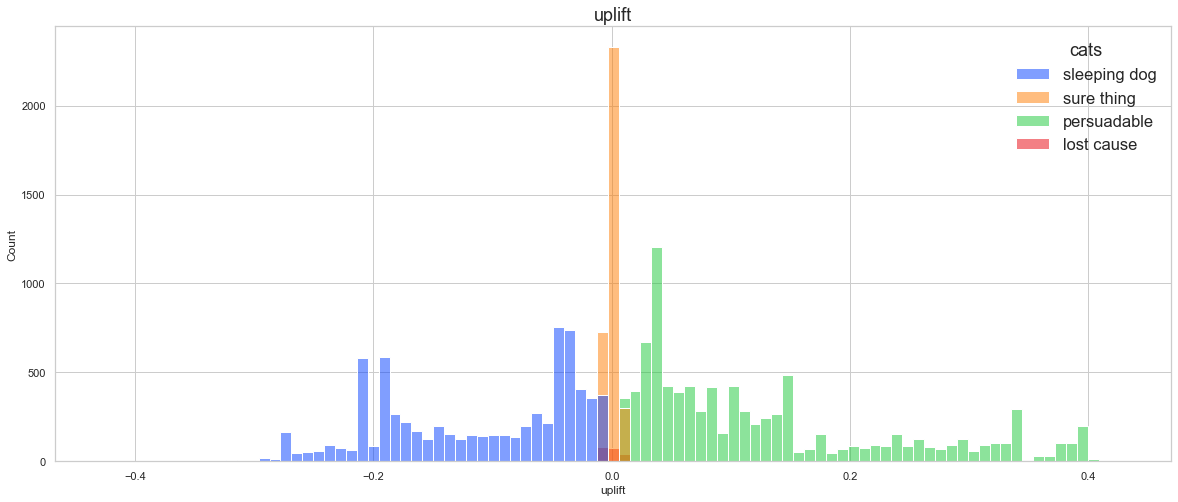

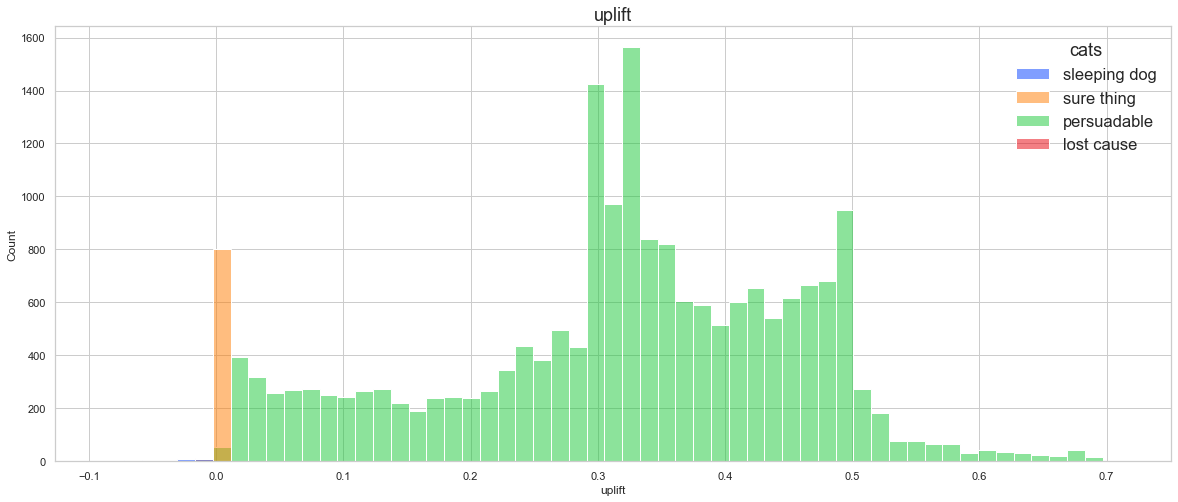

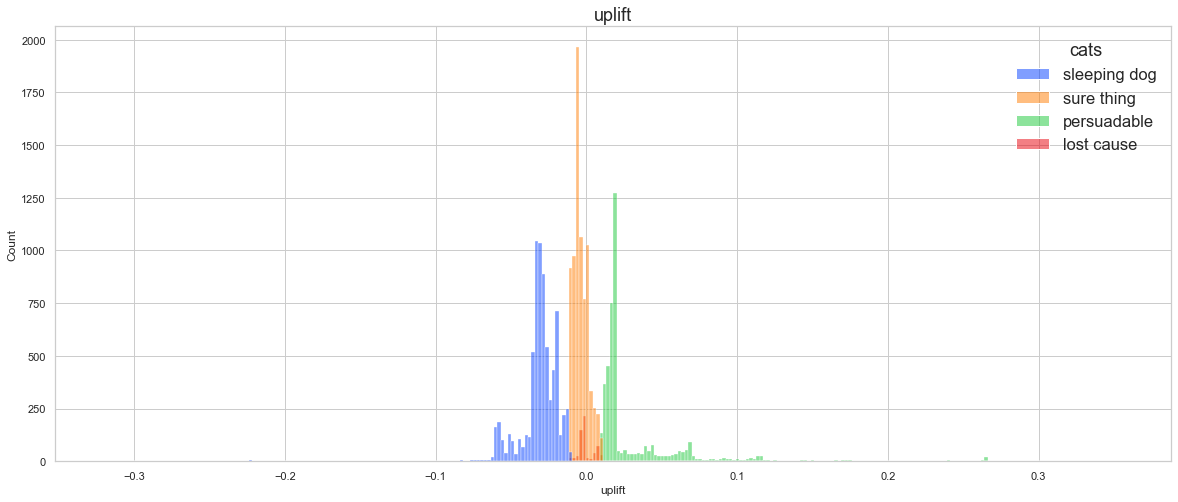

In [50]:
X = m3[['ma2_contactid__c', 'Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender','days_spent_on_app',
       'Num of logins in past 3 mth', 'channel_Email',
       'channel_Inbox Only', 'channel_PN + Inbox', 'channel_PushNotification',
       'channel_SMS', 'App source_Uni roadshow',
       'App source_Leaflet', 'App source_Canvas', 'App source_FB',
       'App source_Insta', 'App source_QR', 'App source_SMS',
       'App source_Affliate', 'App source_Google ads', 'App source_Organic',
       'App source_Others']]

#Goal is buy more pdts 
new_var = pd.get_dummies(trans_unique[['category', 'ma2_contactid__c']], columns = ['category'], prefix='', prefix_sep='')
X = pd.merge(new_var, X, on='ma2_contactid__c',how='left')

y = pd.merge(trans, X, on='ma2_contactid__c',how='right')
X = X.drop(['ma2_contactid__c'], axis=1)

y = y["Products bought"]

def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

y = pct_rank_qcut(y, 2)
y = y.replace({1: 0, 2: 1})

output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1) #X.drop([var], axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=10)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');

output_coup2 = output_df
output_coup2 = output_coup2.set_index("Variable")
output_coup2.sort_values("Uplift Score", ascending = False, inplace = True)
output_coup2

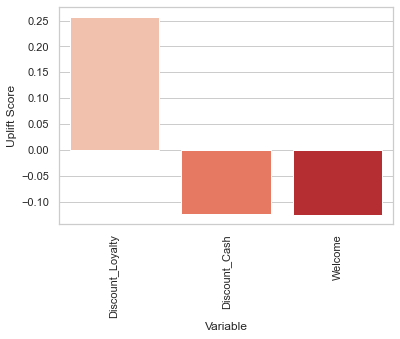

In [51]:
sns.set(style="whitegrid", color_codes=True)

data = output_coup2.reset_index()

pal = sns.color_palette("Reds_r", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()

### The most effective coupons resulting in more products bought with the coupon is: 1. discount loyalty > 2. discount cash coupon > 3. welcome coupon

# Coupon names

In [52]:
X = m3[['ma2_contactid__c', 'Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender','days_spent_on_app',
       'Num of logins in past 3 mth', 'channel_Email',
       'channel_Inbox Only', 'channel_PN + Inbox', 'channel_PushNotification',
       'channel_SMS', 'App source_Uni roadshow',
       'App source_Leaflet', 'App source_Canvas', 'App source_FB',
       'App source_Insta', 'App source_QR', 'App source_SMS',
       'App source_Affliate', 'App source_Google ads', 'App source_Organic',
       'App source_Others']]

In [53]:
#Goal is use coupon
trans_unique_cut = trans_unique[trans_unique["ma2_couponname__c"].isin(trans_unique["ma2_couponname__c"].value_counts().head(10).index.to_series())]
trans_unique_cut = trans_unique_cut.groupby('ma2_couponname__c').apply(lambda x: x.sample(950)).reset_index(drop = True)

new_var = pd.get_dummies(trans_unique_cut[['ma2_couponname__c', 'ma2_contactid__c', 'Days since coup issue']], columns = ['ma2_couponname__c'], prefix='', prefix_sep='')
X = pd.merge(new_var, X, on='ma2_contactid__c',how='left')

y = pd.merge(trans, X, on='ma2_contactid__c',how='right')
X = X.drop(['ma2_contactid__c', 'Days since coup issue'], axis=1)

y = y['Days since coup issue']

def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

y = pct_rank_qcut(y, 2)
y = y.replace({1: 0, 2: 1})

In [55]:
ls = ['$30 MyACUVUE® Dollar 優惠劵', '$80 MyACUVUE® Dollar 優惠劵',
       'DEFINE 買2盒減$100', 'Oasys 1-Day', 'Oasys 1-Day Astigmatism',
       'Oasys 1-Day Series $100 Offer', 'Oasys 1-Day Series $150 Offer',
       'Oasys 1-Day Series $180 Offer', 'Welcome Offer (2 box $50)',
       'Welcome Offer (4 box)']

average uplift: -0.0880
average uplift: 0.4569
average uplift: -0.8735
average uplift: -0.2411
average uplift: -0.3493
average uplift: 0.1676
average uplift: 0.1644
average uplift: 0.4682
average uplift: nan
average uplift: 0.3664


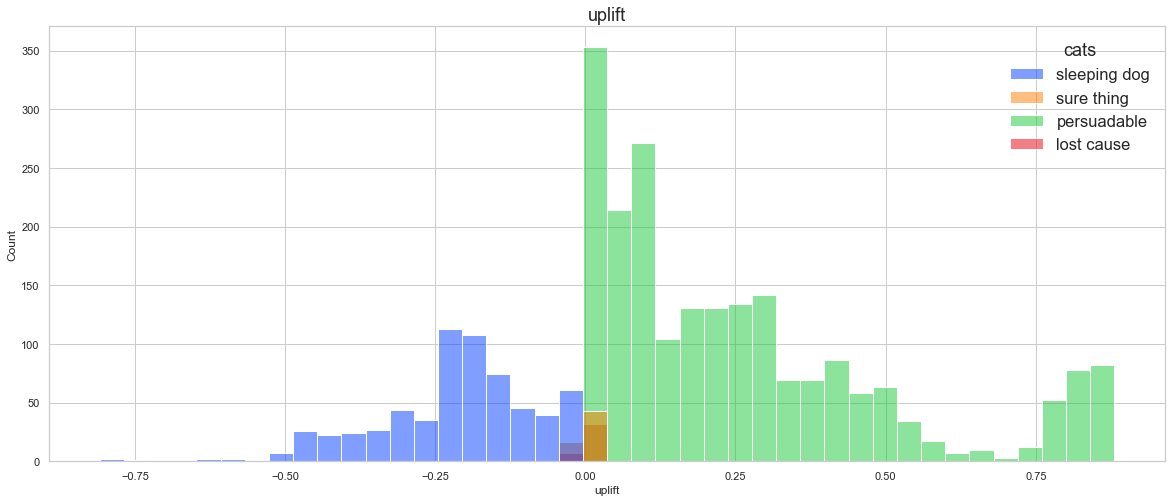

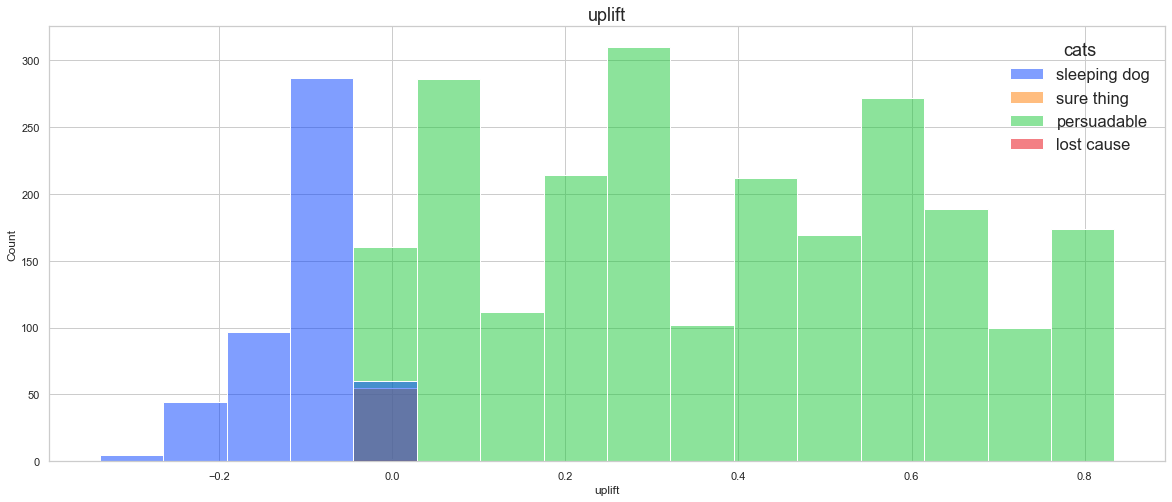

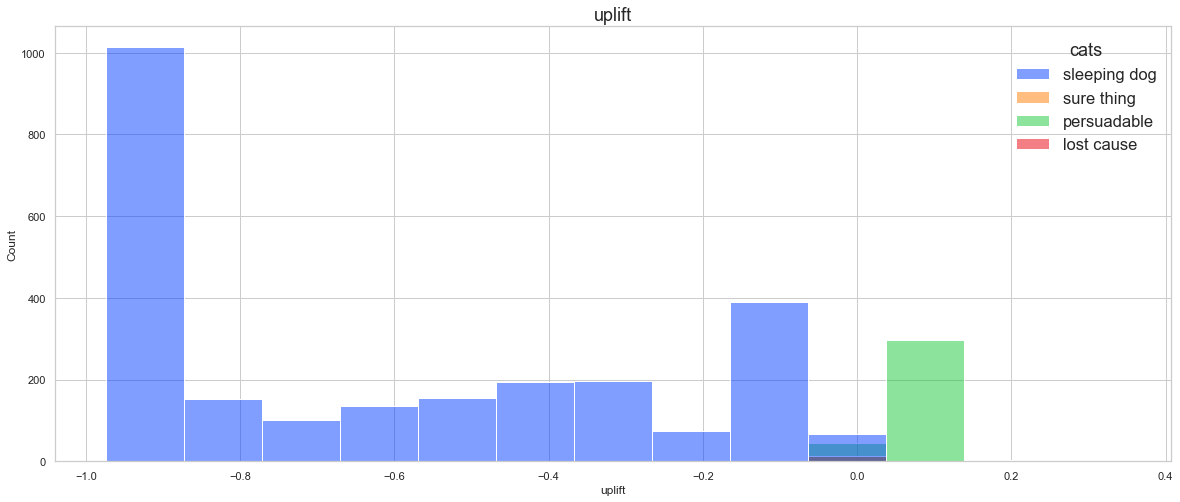

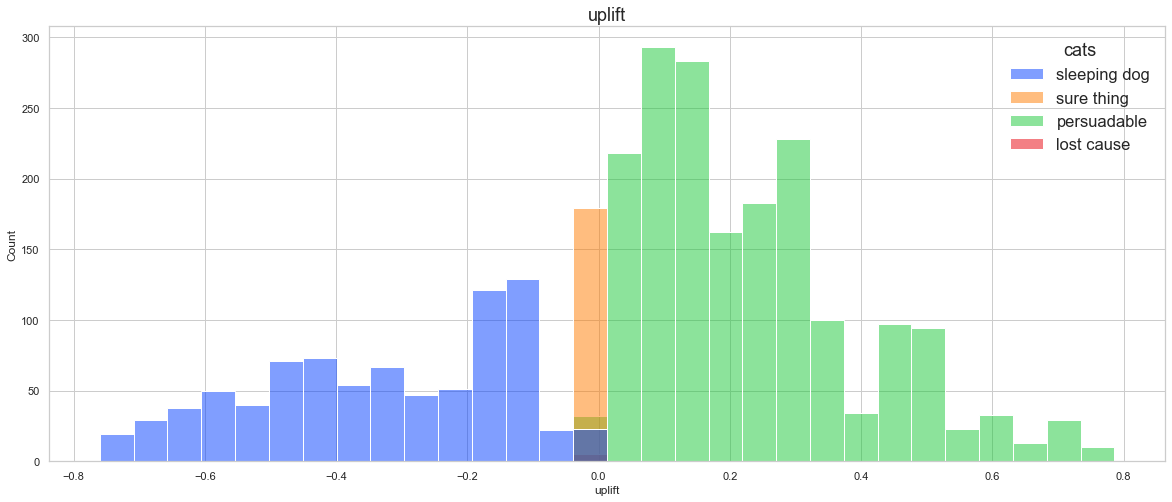

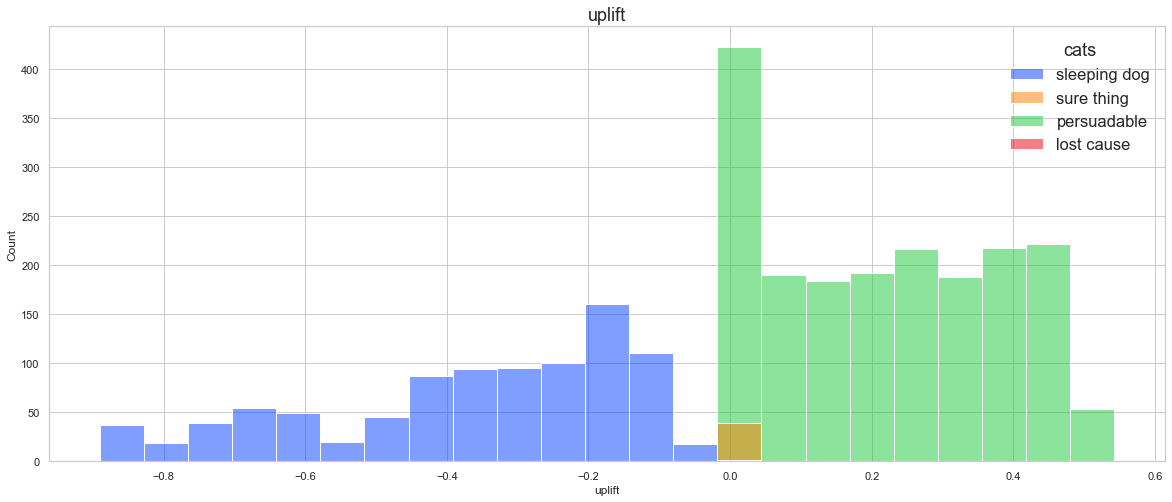

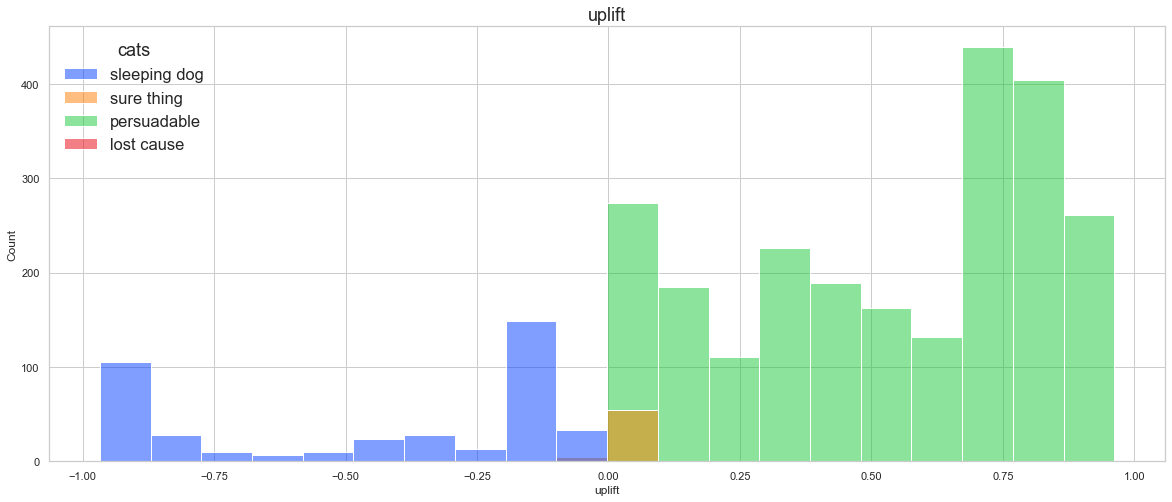

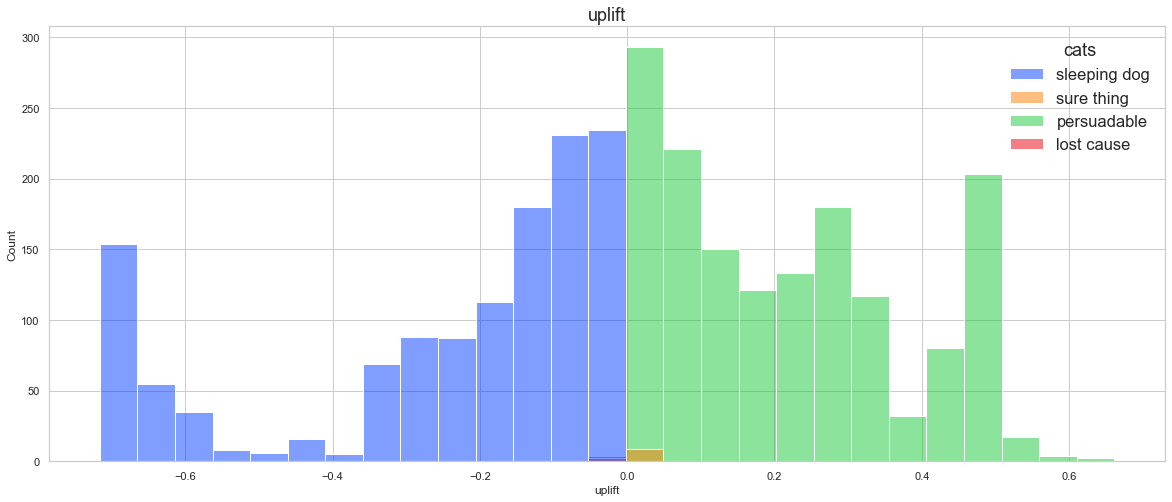

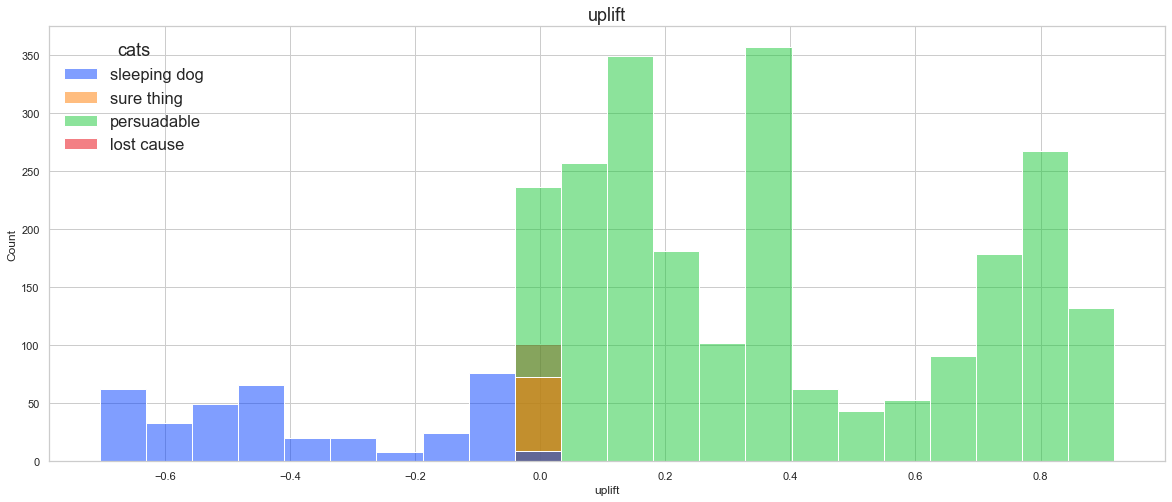

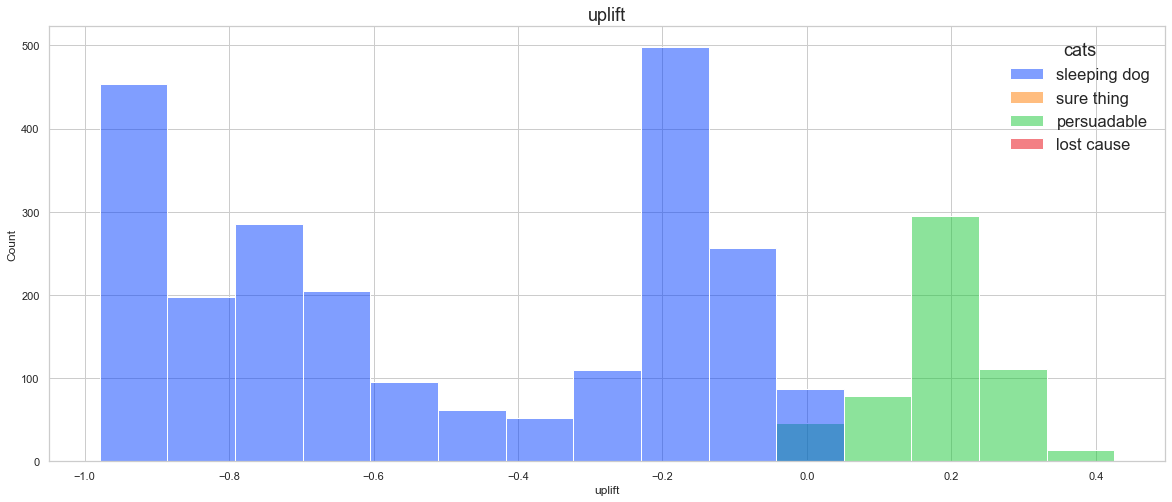

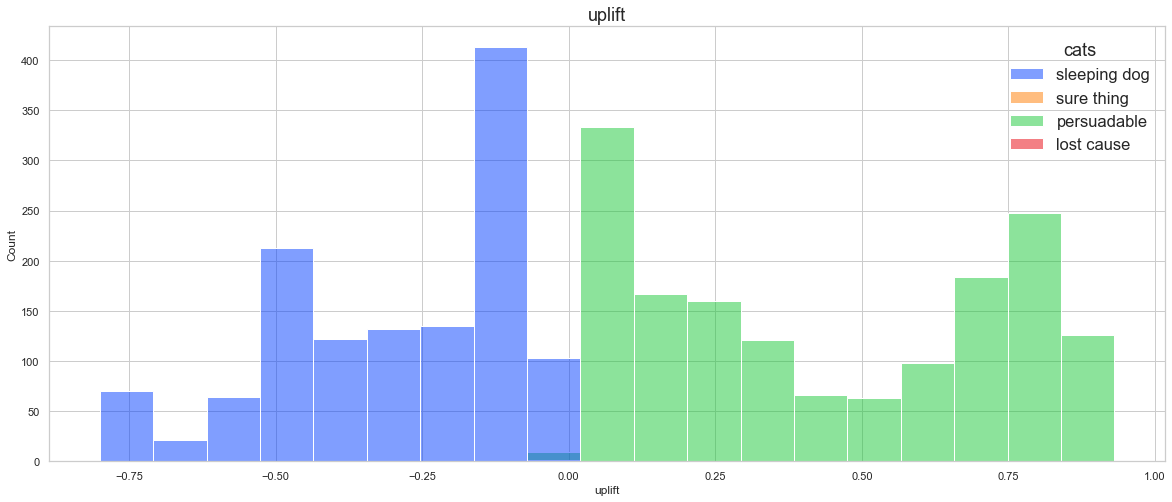

In [57]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=2)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [58]:
output_name = output_df
# output_name = output_name.set_index("Variable")
# output_name.sort_values("Uplift Score", ascending = False, inplace = True)
# output_name

In [59]:
output_name.sort_values("Uplift Score", ascending = False, inplace = True)
output_name.index = np.arange(1,len(output_name)+1)
output_name

,Variable,Uplift Score
1,Oasys 1-Day Series $180 Offer,0.47
2,$80 MyACUVUE® Dollar 優惠劵,0.46
3,Welcome Offer (4 box),0.37
4,Oasys 1-Day Series $100 Offer,0.17
5,Oasys 1-Day Series $150 Offer,0.16
6,$30 MyACUVUE® Dollar 優惠劵,-0.09
7,Oasys 1-Day,-0.24
8,Oasys 1-Day Astigmatism,-0.35
9,DEFINE 買2盒減$100,-0.87
10,Welcome Offer (2 box $50),NaN


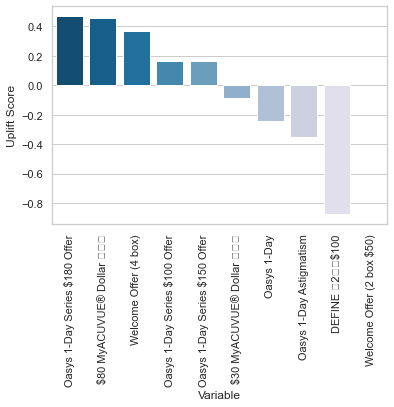

In [60]:
sns.set(style="whitegrid", color_codes=True)

data = output_name.reset_index()

pal = sns.color_palette("PuBu", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()

### The most effective coupons resulting in quicker coupon usage is: 1. 1-day 180 offer > 2. 80 MyAcuvue Dollar > 3. 4 box welcome offer

# Product Cat

In [64]:
X = m3[['ma2_contactid__c', 'Age', 'Length of wearing CL', 'Repurchased flag', 'Referred by friend',
       'Spectacles flag', 'Mths registered', 'Gender','days_spent_on_app',
       'Num of logins in past 3 mth', 'App User']]


In [65]:
new_var = pd.get_dummies(trans_unique[['brand_category', 'ma2_contactid__c']], columns = ['brand_category'], prefix='', prefix_sep='')
X = pd.merge(new_var, X, on='ma2_contactid__c',how='left')

y = pd.merge(trans, X, on='ma2_contactid__c',how='right')
X = X.drop(['ma2_contactid__c'], axis=1)

y = y["Products bought"]

def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

y = pct_rank_qcut(y, 2)
y = y.replace({1: 0, 2: 1})

In [66]:
ls = ['Astigmatism', 'Beauty', 'Presbyopia', 'Spherical']

average uplift: -0.0704
average uplift: -0.0291
average uplift: 0.0951
average uplift: 0.0596


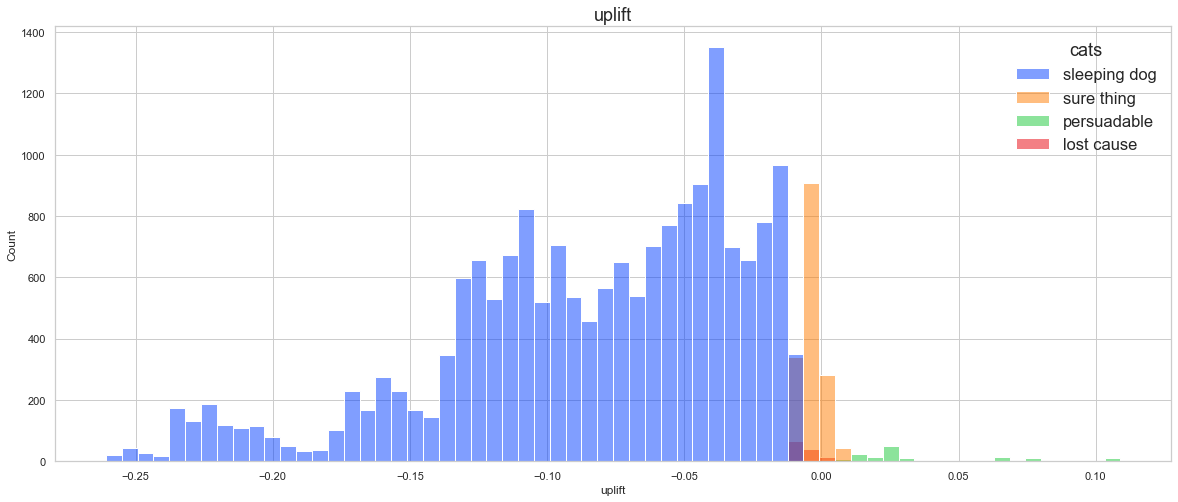

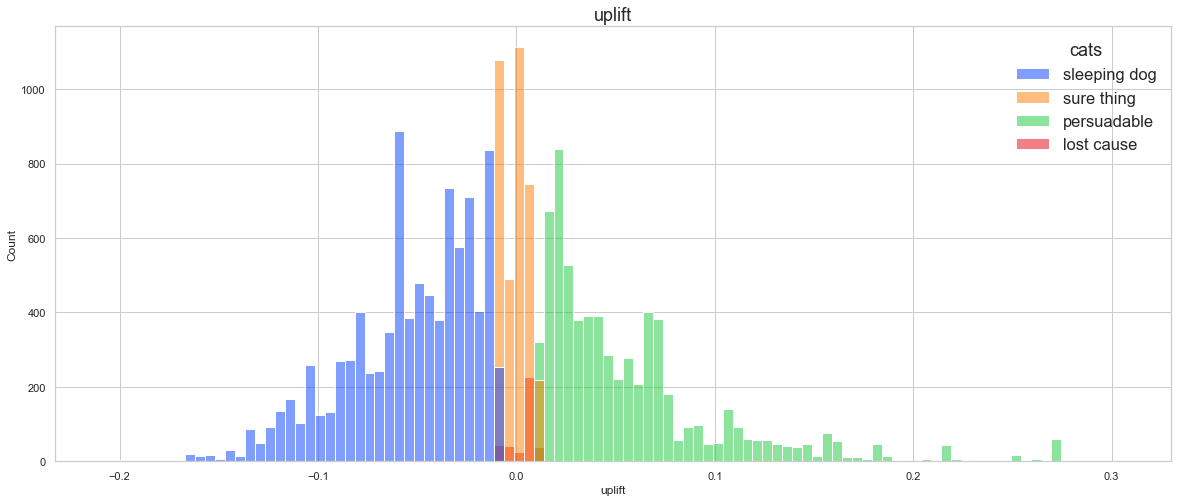

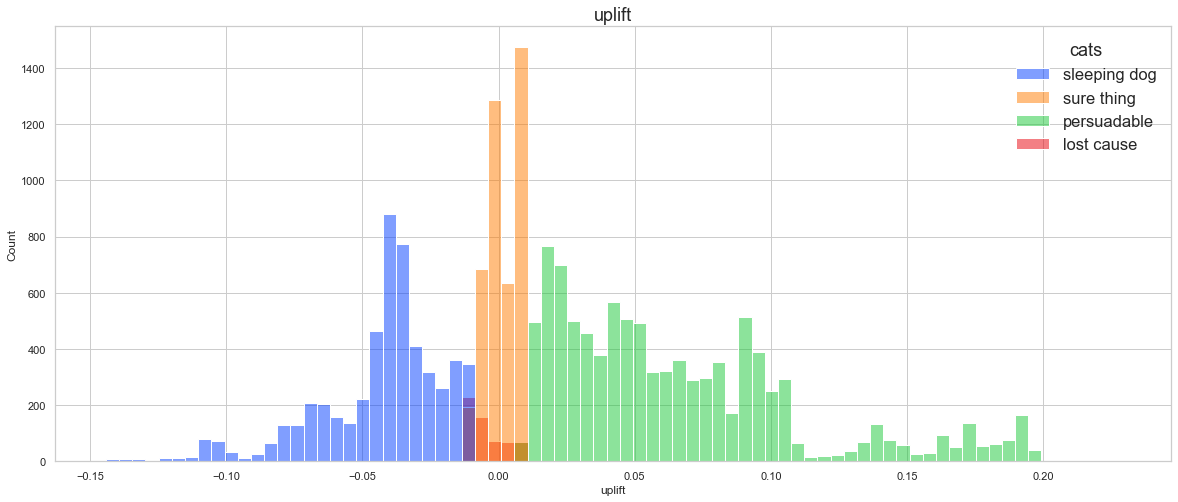

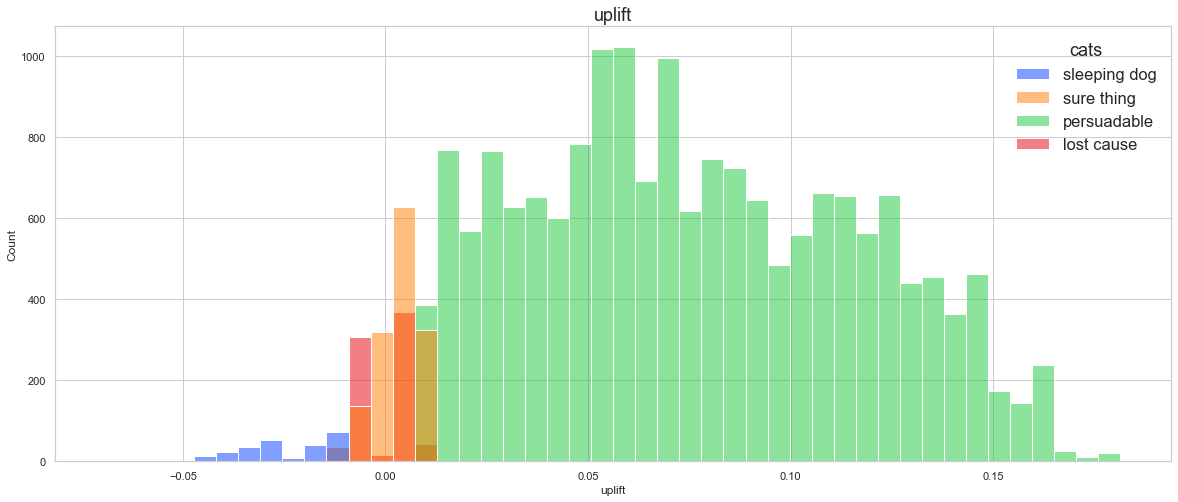

In [67]:
output_df = pd.DataFrame(columns=['Variable', 'Uplift Score'])

for var in ls:
    treat = X[[var]]
    treat[var] = treat[var].replace(np.nan, 0)
    treat[var] = np.where(treat[var] >1, 1, treat[var])

    X_new = X.drop(ls, axis=1)
        
    dfT = pd.concat([treat.reset_index(drop = True), y.reset_index(drop=True)], axis=1)

    X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(   
                                X_new,
                                treat,
                                y,
                                stratify=dfT,
                                test_size=TST,
                                random_state=RND)

    estimator_sm = CatBoostClassifier(  iterations = 20, 
                                        thread_count = THREADc, 
                                        random_state = RND, 
                                        silent = True)
    model_sm = SoloModel(estimator_sm)
    model_sm = model_sm.fit(    X = X_train, 
                                y = y_train, 
                                treatment = treat_train, 
                                estimator_fit_params={"cat_features": None})

    # model results: uplift
    pred_uplift_sm = model_sm.predict(X_test)

    y_df = pd.DataFrame(y_test)

    uplift_sm_avg = weighted_average_uplift(y_df, pred_uplift_sm, treat_test, bins=10)


    print(f"average uplift: {uplift_sm_avg:.4f}")


    output_df = output_df.append({'Variable' : var, 'Uplift Score' : uplift_sm_avg}, ignore_index = True)

    # uplift by customer
    dfZ = pd.DataFrame()
    dfZ["prob_treat"] = model_sm.trmnt_preds_   
    dfZ["prob_control"] = model_sm.ctrl_preds_   
    dfZ["uplift"] = pred_uplift_sm
    dfZ.sort_values("uplift", inplace=True, ascending=False)   

    # classify customers by their response probabilities
    cutbins = [-1, -0.01, 0.01, 1]
    cutlabels = ["sleeping dog", "sure thing", "persuadable"]
    dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


    # sure things needs to be split between lost causes and real sure things
    dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
    dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
    dfZ.sort_values("uplift", ascending=False)
    #print(dfZ)
    
    # uplift by customer category
    pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")
    
    # uplift by category
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(20, 8))
    with sns.plotting_context("notebook", font_scale=1.5):
        sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
        ax.set_title('uplift');


In [68]:
output_cat = output_df
output_cat = output_cat.set_index("Variable")
output_cat.sort_values("Uplift Score", ascending = False, inplace = True)
output_cat

,Uplift Score
Variable,
Presbyopia,0.10
Spherical,0.06
Beauty,-0.03
Astigmatism,-0.07


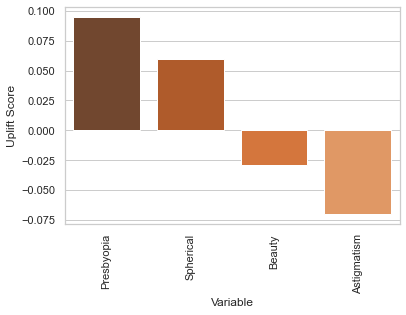

In [69]:
sns.set(style="whitegrid", color_codes=True)

data = output_cat.reset_index()

pal = sns.color_palette("Oranges_d", len(data))
rank = data["Uplift Score"].argsort().argsort()
plt.xticks(rotation=90)
sns.barplot(y=data["Uplift Score"], x=data["Variable"], palette=np.array(pal[::-1])[-rank-1])

plt.show()

### The recommended product category with more products purchased is: 1. Presbyopia > 2. Spherical > 3. Beauty